**COVID-19 Data Wrangling - Observing COVID-19's effect on the general population, races/ethnicities within the population, other demographics within the population such as age, and the economy.**

Group Members:

* Monica Orme
* Jess Herbert
* Diana Valderrama
* Jacob Mcgraw

**Code written by Jess Herbert**

The code shown below displays data wrangling to:


*   Plot distributions of monthly cases and deaths
* Create & plot 'Deaths by Race' Estimations
*   Plot county cumulative vaccination administration rates by race against state cumulative rates and county population demographics

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt

#IMPORT THE FILE WHICH CONTAINS CA CASES/DEATHS,ETC. FOR EACH DAY BY GEOGRAPHIC REGION
cases_file='CA_covid_cases.deaths.tests.csv'
cases=pd.read_csv(cases_file)

#SUBSET TO COUNTY LEVEL
cases=cases.loc[cases['area_type']=='County']

#CREATE NEW DATE COLUMN BY REARRANGING CURRENT DATE COLUMN'S VALUES
newdatecol=[]
for i in cases.date.values:
    newdate=str(i[5:])+'-'+str(i[0:4])
    newdatecol.append(newdate)

#ADD THE NEW COLUMN TO THE DATA FRAME
cases['Date']=newdatecol

#SUBSET TO ONLY COLUMNS OF INTEREST
cases=cases[['Date','area','population','cases','deaths',
            'total_tests','positive_tests','reported_cases',
            'reported_deaths','reported_tests']]

#RENAME COLUMNS TO ABBREVIATE NAMES
cases.columns=['Date','County','Pop','Cases','Deaths',
              'Tot_test','Pos_test','Rep_cases',
              'Rep_deaths','Rep_tests']

#THE MONTHS PRESENT IN OUR DATA ARE:
month_names=['January','February','March','April','May',
            'June','July','August','September','October',
            'November','December']

#THE YEARS PRESENT ARE:
year_names=[2020,2021]

#MAKE A NEW COLUMN TO IDENTIFY MONTH
month_col=[]
for i in cases.Date.values:
    if int(i[0:1])==0:
        numeric_month=int(i[1:2])
        month_col.append(month_names[numeric_month-1])
    else:
        numeric_month=int(i[0:2])
        month_col.append(month_names[numeric_month-1])

#ADD THAT COLUMN TO THE DATA FRAME
cases['Month']=month_col

#MAKE A NEW COLUMN TO IDENTIFY YEAR
year_col=[]
for i in cases.Date.values:
    if int(i[-4:])==year_names[0]:
        year_col.append(year_names[0])
    else:
        year_col.append(year_names[1])

#ADD THAT COLUMN TO THE DATA FRAME
cases['Year']=year_col

#REARRANGE COLUMNS TO HAVE THE 2 NEW CATEGORICAL COLUMNS UP FRONT
cases=cases[['Year','Month','Date','County','Pop','Cases',
              'Deaths','Tot_test','Pos_test','Rep_cases',
              'Rep_deaths','Rep_tests']]

#LOOKING AT THE LEVELS OF 'COUNTY' WE SEE A FEW
#VALUES THAT WE WANT TO REMOVE FROM THE ANALYSIS
#SO FILTER THOSE ROWS OUT
cases=cases[(cases['County']!='Unknown')&(cases['County']!='Out of state')]

#WE NEED TO REMOVE MISSING BLANK VALUES
#WHICH ARE DEFINED AS 0 BY THE DATA DICTIONARY 

#CREATE NEW COLUMNS TO REMOVE NAN WHEREVER PRESENT
#FOR THE 'CASES' COLUMN
new_cases=[]
for i in cases.Cases:
    if math.isnan(i):
        new_cases.append(float(0))
    else:
        new_cases.append(i)

#FOR 'DEATHS'
new_deaths=[]
for i in cases.Deaths:
    if math.isnan(i):
        new_deaths.append(float(0))
    else:
        new_deaths.append(i)
        
#FOR 'TOTAL TESTS'
newtot_test=[]
for i in cases.Tot_test:
    if math.isnan(i):
        newtot_test.append(float(0))
    else:
        newtot_test.append(i)

#FOR 'POSITIVE TESTS'
newpos_test=[]
for i in cases.Pos_test:
    if math.isnan(i):
        newpos_test.append(float(0))
    else:
        newpos_test.append(i)
        
#FOR 'REPORTED TESTS'
newrep_test=[]
for i in cases.Rep_tests:
    if math.isnan(i):
        newrep_test.append(float(0))
    else:
        newrep_test.append(i)

#REPLACE THE OLD COLUMNS WITH THE NEW ONES
cases['Cases']=new_cases
cases['Deaths']=new_deaths
cases['Tot_test']=newtot_test
cases['Pos_test']=newpos_test
cases['Rep_tests']=newrep_test

#BASED ON THE DATA DICTIONARY
#WE NEED TO MAKE SOME ADJUSTMENTS TO ACCOUNT FOR THE DIFFERENCE
#BETWEEN CASES AND REPORTED CASES/DEATHS AND REPORTED DEATHS

#FOR THE NUMBER OF CASES
cleaned_casecol=[]
for i in range(len(cases)):
    a=cases.Cases.values[i]
    b=cases.Rep_cases.values[i]
    m=max(a,b)
    cleaned_casecol.append(m)

#FOR THE NUMBER OF DEATHS
cleaned_deathscol=[]
for i in range(len(cases)):
    a=cases.Deaths.values[i]
    b=cases.Rep_deaths.values[i]
    m=max(a,b)
    cleaned_deathscol.append(m)

#REPLACE OLD COLUMNS WITH CLEANED COLUMNS
cases['Cases']=cleaned_casecol
cases['Deaths']=cleaned_deathscol

#SUBSET TO REMOVE OLD COLUMNS
cases=cases[['Year','Month','Date','County','Pop',
           'Cases','Deaths','Tot_test','Pos_test']]

In [ ]:
#NOW WE ARE READY TO DO SOME CALCULATIONS
#BEFORE SUMMING CASES, DEATHS, ETC, OVER MONTHS,
#WE MUST ISOLATE POPULATION SO IT DOESNT GET SUMMED

#COPY THE ORIGINAL FRAME TO AVOID ERRORS
countypops=cases.copy(deep=True)
countypops=countypops[['County','Pop']]

#DROP DUPLICATE ROWS AS POPULATION IS CONSTANT
countypops.drop_duplicates(keep='first',inplace=True)

#ISOLATE EVERYTHING BESIDES POPULATION
cases2=cases.copy(deep=True)
cases2=cases2[['Year','Month','County','Cases','Deaths','Tot_test','Pos_test']]

#SUM ACROSS NUMERIC VARIABLES
cases2=cases2.groupby(['Year','Month','County']).sum()

#RESET THE INDEX SO MONTH, YEAR, COUNTY ARE STILL CATEGORICAL VARIABLES
cases2.reset_index(inplace=True)

#MERGE THE 2 TOGETHER TO REINTRODUCE POPULATION
cases2=pd.merge(countypops,cases2,on='County')

#CALCULATE RV FOR CASES AS PCT OF COUNTY POP BY MONTH
#(PER 100K)
case_100k=[]
for i in range(len(cases2)):
    num=cases2.Cases[i]
    den=(cases2.Pop[i]/100000)
    pct=round((num/den),1)
    case_100k.append(pct)

#CALCULATE RV FOR DEATHS AS PCT OF COUNTY POP BY MONTH
#(PER 100K)
death_100k=[]
for i in range(len(cases2)):
    num=cases2.Deaths[i]
    den=(cases2.Pop[i]/100000)
    pct=round((num/den),1)
    death_100k.append(pct)
    
#CALCULATE RV FOR TEST POSITIVITY RATE BY MONTH
postestrate=[]
for i in range(len(cases2)):
    num=cases2.Pos_test[i]
    den=cases2.Tot_test[i]
    if den==0:
        postestrate.append(0)
    else:
        pct=round(((num/den)*100),3)
        postestrate.append(pct)

#ADD NEW COLUMNS FOR THESE RVS
cases2['Case_100k']=case_100k
cases2['Death_100k']=death_100k
cases2['Pos_test_rate']=postestrate


#USING CA TIERS - ASSIGN CATEGORICAL VARIABLE BASED ON POS TEST RATE
posrate_tier=[]
for i in range(len(cases2)):
    x=cases2.Pos_test_rate[i]
    t='gold'
    if (x>=2)&(x<5):
        t='tab:orange'
    elif (x>=5)&(x<=8):
        t='tab:red'
    elif x>8:
        t='tab:purple'
    posrate_tier.append(t)

#USING CA TIERS - ASSIGN CATEGORICAL VARIABLE BASED ON NUMBER OF CASES
cases_tier=[]
for i in range(len(cases2)):
    x=cases2.Case_100k[i]
    t='gold'
    if (x>=60)&(x<180):
        t='tab:orange'
    elif (x>=180)&(x<=300):
        t='tab:red'
    elif x>300:
        t='tab:purple'
    cases_tier.append(t)

cases2['Tier_posrate']=posrate_tier
cases2['Tier_newcases100k']=cases_tier

In [ ]:
#MAKE DEEP COPIES AND THEN SUBSET TO ONLY
#COUNTIES OF INTEREST, 1 BY 1, SUCH THAT WE
#HAVE SEPARATE FRAMES FOR EACH COUNTY

#SACRAMENTO COUNTY
sacramento=cases2.copy(deep=True)
sacramento=sacramento.loc[sacramento.County=='Sacramento']

#COLUSA COUNTY
colusa=cases2.copy(deep=True)
colusa=colusa.loc[colusa.County=='Colusa']

#LOS ANGELES COUNTY
la=cases2.copy(deep=True)
la=la.loc[la.County=='Los Angeles']

#SANTA CLARA COUNTY
sc=cases2.copy(deep=True)
sc=sc.loc[sc.County=='Santa Clara']

#WE DONT HAVE DATA FOR JAN 2020, AND ONLY JAN-APR 2021,
#SO REARRANGE MONTH_NAMES FOR EASIER LOOPING
ordered_months=month_names[1:]+month_names[0:4]

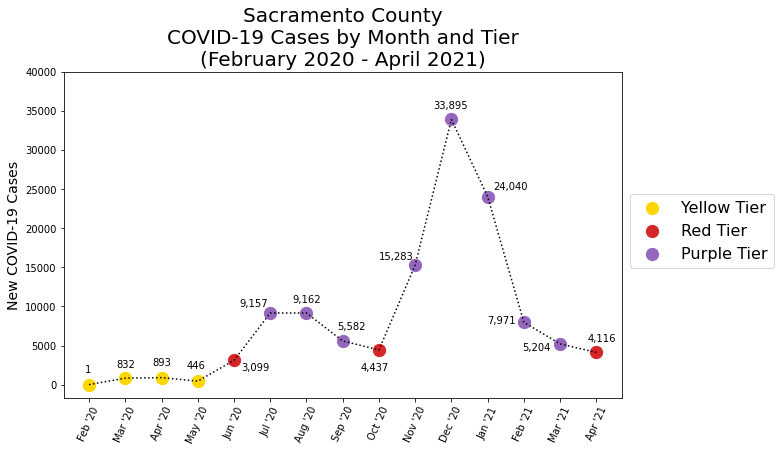

In [ ]:
#PLOT CASES BY MONTH AND TIER FOR EACH OF THE COUNTIES:

#MAKE X TICK LABELS
ordered_month_year=[]

for i in range(len(ordered_months)):
    if i<=10:
        d=ordered_months[i][0:3]+" '"+str(year_names[0])[2:]
        ordered_month_year.append(d)
    else:
        d=ordered_months[i][0:3]+" '"+str(year_names[1])[2:]
        ordered_month_year.append(d)

#FOR SACRAMENTO
saccases=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2020)].Cases.values)
        saccases.append(yi)
        c=sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2021)].Cases.values)
        saccases.append(yi)
        c=sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),saccases,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Sacramento County\nCOVID-19 Cases by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','_nolegend_','_nolegend_','_nolegend_',
           'Red Tier','Purple Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Cases',fontsize=14)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66)

#EXTEND Y LIMIT
plt.ylim(top=40000);

#ADD DATA LABELS TO PLOT
plt.annotate('1',(-.125,1500))
plt.annotate('832',(.75,2200))
plt.annotate('893',(1.75,2500))
plt.annotate('446',(2.7,2000))
plt.annotate('3,099',(4.2,1850))
plt.annotate('9,157',(4.15,10000))
plt.annotate('9,162',(5.6,10500))
plt.annotate('5,582',(6.85,7000))
plt.annotate('4,437',(7.5,1750))
plt.annotate('15,283',(8,16000))
plt.annotate('33,895',(9.5,35300))
plt.annotate('24,040',(11.15,24900))
plt.annotate('7,971',(11,7850))
plt.annotate('5,204',(11.95,4400))
plt.annotate('4,116',(13.75,5500));
plt.gcf().set_size_inches(10,6)
#plt.savefig('Sac_Cases.png',bbox_inches='tight')

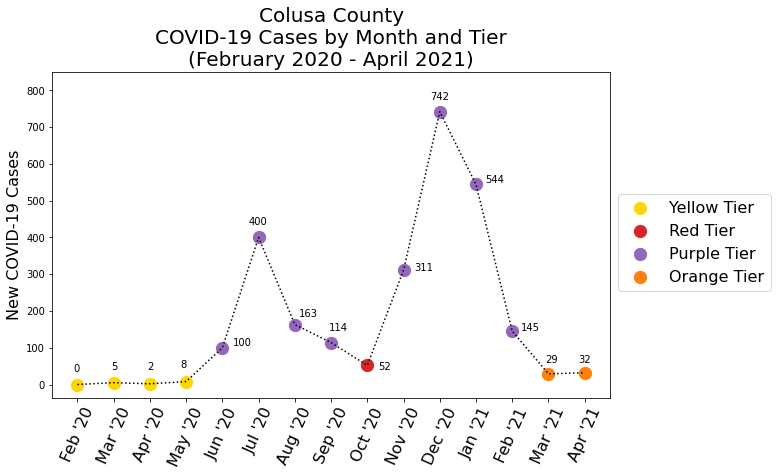

In [ ]:
#FOR COLUSA
colusacases=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2020)].Cases.values)
        colusacases.append(yi)
        c=colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2021)].Cases.values)
        colusacases.append(yi)
        c=colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),colusacases,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Colusa County\nCOVID-19 Cases by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
           'Red Tier','Purple Tier','_nolegend_',
           '_nolegend_','_nolegend_','_nolegend_',
           'Orange Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Cases',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=850);

#ADD DATA LABELS TO PLOT
plt.annotate('0',(-.1,35))
plt.annotate('5',(.925,40))
plt.annotate('2',(1.925,40))
plt.annotate('8',(2.85,45))
plt.annotate('100',(4.3,105))
plt.annotate('400',(4.72,435))
plt.annotate('163',(6.1,185))
plt.annotate('114',(6.95,145))
plt.annotate('52',(8.3,40))
plt.annotate('311',(9.3,310))
plt.annotate('742',(9.725,775))
plt.annotate('544',(11.25,550))
plt.annotate('145',(12.25,145))
plt.annotate('29',(12.9,60))
plt.annotate('32',(13.825,60));
plt.gcf().set_size_inches(10,6)
#plt.savefig('Colusa_Cases.png',bbox_inches='tight')

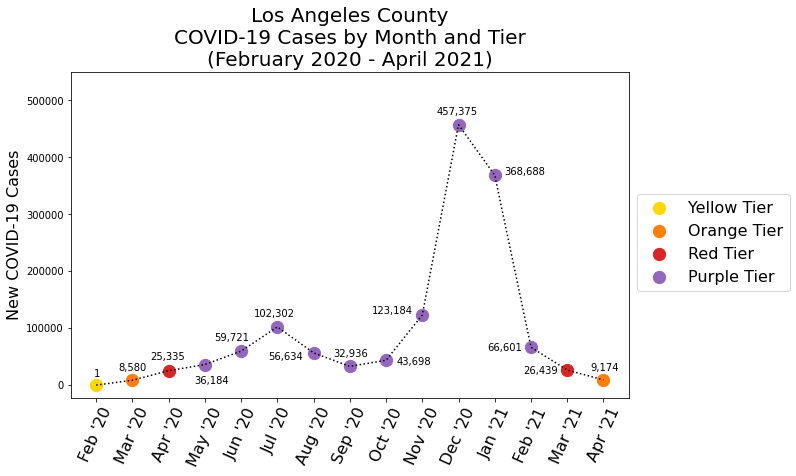

In [ ]:
#FOR LOS ANGELES
lacases=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2020)].Cases.values)
        lacases.append(yi)
        c=la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2021)].Cases.values)
        lacases.append(yi)
        c=la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),lacases,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Los Angeles County\nCOVID-19 Cases by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','Orange Tier','Red Tier','Purple Tier'],
           fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Cases',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=550000);

#ADD DATA LABELS TO PLOT
plt.annotate('1',(-.075,15000))
plt.annotate('8,580',(.6,25000))
plt.annotate('25,335',(1.5,45000))
plt.annotate('36,184',(2.7,2000))
plt.annotate('59,721',(3.25,77500))
plt.annotate('102,302',(4.35,120000))
plt.annotate('56,634',(4.75,45000))
plt.annotate('32,936',(6.55,50000))
plt.annotate('43,698',(8.3,35000))
plt.annotate('123,184',(7.6,125000))
plt.annotate('457,375',(9.4,475000))
plt.annotate('368,688',(11.25,370000))
plt.annotate('66,601',(10.8,60000))
plt.annotate('26,439',(11.8,20500))
plt.annotate('9,174',(13.65,25000));
plt.gcf().set_size_inches(10,6)
#plt.savefig('LA_Cases.png',bbox_inches='tight')

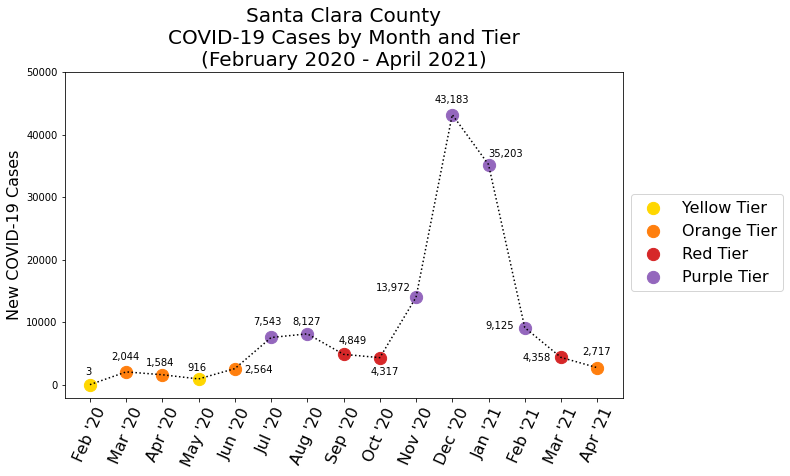

In [ ]:
#FOR SANTA CLARA
sccases=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2020)].Cases.values)
        sccases.append(yi)
        c=sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2021)].Cases.values)
        sccases.append(yi)
        c=sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),sccases,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Santa Clara County\nCOVID-19 Cases by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','Orange Tier','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','Red Tier',
            '_nolegend_','Purple Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Cases',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
            labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=50000);

#ADD DATA LABELS TO PLOT
plt.annotate('3',(-.125,1500))
plt.annotate('2,044',(.6,4000))
plt.annotate('1,584',(1.55,3000))
plt.annotate('916',(2.7,2250))
plt.annotate('2,564',(4.25,1850))
plt.annotate('7,543',(4.5,9500))
plt.annotate('8,127',(5.6,9500))
plt.annotate('4,849',(6.85,6500))
plt.annotate('4,317',(7.75,1500))
plt.annotate('13,972',(7.9,15000))
plt.annotate('43,183',(9.5,45000))
plt.annotate('35,203',(11,36500))
plt.annotate('9,125',(10.9,9000))
plt.annotate('4,358',(11.95,3750))
plt.annotate('2,717',(13.6,4750));
plt.gcf().set_size_inches(10,6)
#plt.savefig('SC_Cases.png',bbox_inches='tight')

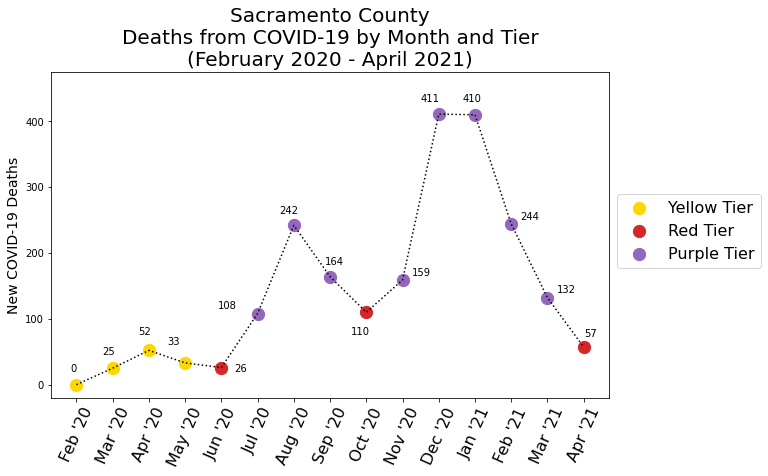

In [ ]:
#PLOT DEATHS BY MONTH AND TIER FOR EACH OF THE COUNTIES:

#FOR SACRAMENTO
sacdeaths=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2020)].Deaths.values)
        sacdeaths.append(yi)
        c=sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2021)].Deaths.values)
        sacdeaths.append(yi)
        c=sacramento.loc[(sacramento.Month==str(ordered_months[i]))&(sacramento.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),sacdeaths,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Sacramento County\nDeaths from COVID-19 by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','_nolegend_','_nolegend_','_nolegend_',
           'Red Tier','Purple Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Deaths',fontsize=14)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=475)

#ADD DATA LABELS TO PLOT
plt.annotate('0',(-.1655,20))
plt.annotate('25',(.7,45))
plt.annotate('52',(1.7,75))
plt.annotate('33',(2.5,60))
plt.annotate('26',(4.35,20))
plt.annotate('108',(3.9,115))
plt.annotate('242',(5.6,260))
plt.annotate('164',(6.85,182))
plt.annotate('110',(7.58,75))
plt.annotate('159',(9.25,165))
plt.annotate('411',(9.5,430))
plt.annotate('410',(10.65,430))
plt.annotate('244',(12.25,250))
plt.annotate('132',(13.25,140))
plt.annotate('57',(14,72));
plt.gcf().set_size_inches(10,6)
#plt.savefig('Sac_Deaths.png',bbox_inches='tight')

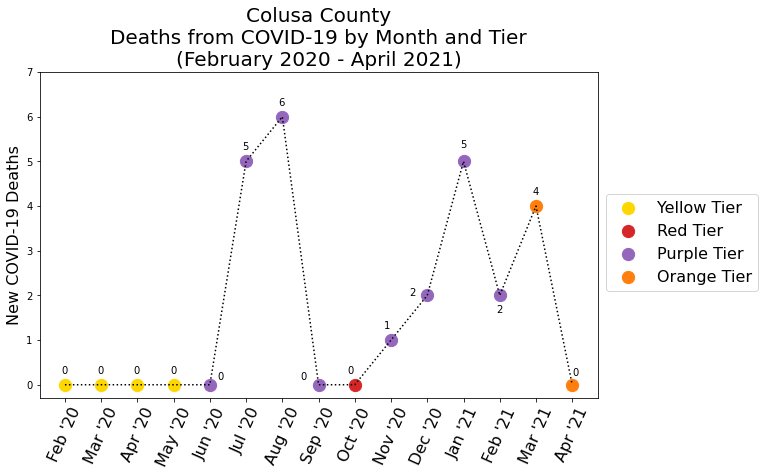

In [ ]:
#FOR COLUSA
colusadeaths=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2020)].Deaths.values)
        colusadeaths.append(yi)
        c=colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2021)].Deaths.values)
        colusadeaths.append(yi)
        c=colusa.loc[(colusa.Month==str(ordered_months[i]))&(colusa.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),colusadeaths,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Colusa County\nDeaths from COVID-19 by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','_nolegend_','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','_nolegend_',
            'Red Tier', '_nolegend_','_nolegend_','_nolegend_',
           'Purple Tier','Orange Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Deaths',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=7)

#ADD DATA LABELS TO PLOT
plt.annotate('0',(-.1,.25))
plt.annotate('0',(.9,.25))
plt.annotate('0',(1.9,.25))
plt.annotate('0',(2.9,.25))
plt.annotate('0',(4.2,.1))
plt.annotate('5',(4.9,5.25))
plt.annotate('6',(5.9,6.25))
plt.annotate('0',(6.5,.1))
plt.annotate('0',(7.8,.25))
plt.annotate('1',(8.8,1.25))
plt.annotate('2',(9.5,2))
plt.annotate('5',(10.9,5.30))
plt.annotate('2',(11.9,1.6))
plt.annotate('4',(12.9,4.25))
plt.annotate('0',(14,.2));
plt.gcf().set_size_inches(10,6)
#plt.savefig('Colusa_Deaths.png',bbox_inches='tight')

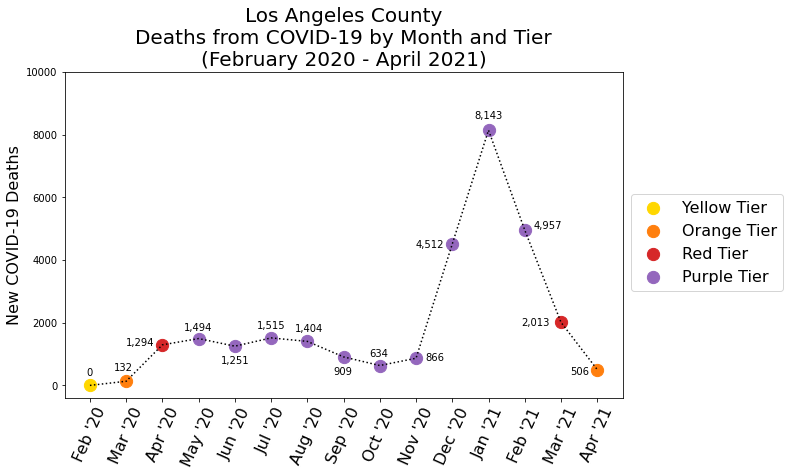

In [ ]:
#FOR LOS ANGELES
ladeaths=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2020)].Deaths.values)
        ladeaths.append(yi)
        c=la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2021)].Deaths.values)
        ladeaths.append(yi)
        c=la.loc[(la.Month==str(ordered_months[i]))&(la.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),ladeaths,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Los Angeles County\nDeaths from COVID-19 by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','Orange Tier','Red Tier','Purple Tier'],
           fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Deaths',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=10000)

#ADD DATA LABELS TO PLOT
plt.annotate('0',(-.1,300))
plt.annotate('132',(.65,450))
plt.annotate('1,294',(1.,1250))
plt.annotate('1,494',(2.6,1750))
plt.annotate('1,251',(3.6,700))
plt.annotate('1,515',(4.6,1800))
plt.annotate('1,404',(5.65,1700))
plt.annotate('909',(6.725,350))
plt.annotate('634',(7.7,900))
plt.annotate('866',(9.25,800))
plt.annotate('4,512',(9,4400))
plt.annotate('8,143',(10.6,8500))
plt.annotate('4,957',(12.25,5000))
plt.annotate('2,013',(11.9,1900))
plt.annotate('506',(13.25,350));
plt.gcf().set_size_inches(10,6)
#plt.savefig('LA_Deaths.png',bbox_inches='tight')

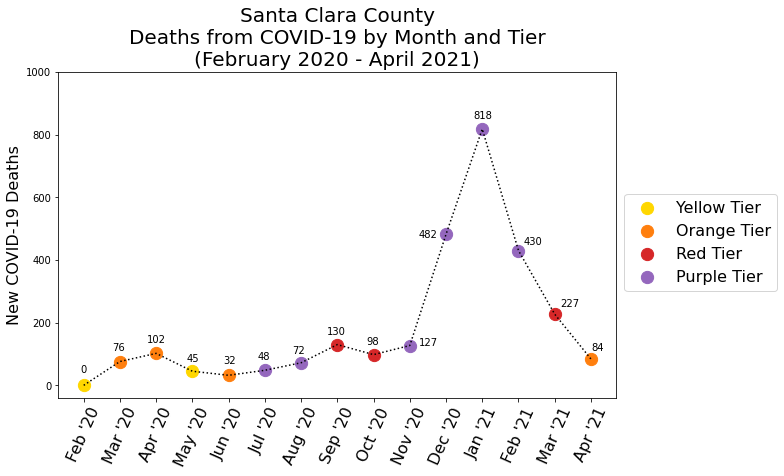

In [ ]:
#FOR SANTA CLARA
scdeaths=[]
for i in range(len(ordered_months)):
    if i <=10:
        yi=int(sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2020)].Deaths.values)
        scdeaths.append(yi)
        c=sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2020)].Tier_newcases100k.values
    else:
        yi=int(sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2021)].Deaths.values)
        scdeaths.append(yi)
        c=sc.loc[(sc.Month==str(ordered_months[i]))&(sc.Year==2021)].Tier_newcases100k.values
    plt.scatter(i,yi,color=c,s=150)

#ADD LINE TO CONNECT SCATTERPLOT'S POINTS
plt.plot(np.arange(0,15),scdeaths,'k:',label='_nolegend_')

#ADD A TITLE, LEGEND, AXIS LABELS, CHANGE X TICKS TO MONTH,YEAR
plt.title('Santa Clara County\nDeaths from COVID-19 by Month and Tier\n(February 2020 - April 2021)',fontsize=20)

plt.legend(['Yellow Tier','Orange Tier','_nolegend_','_nolegend_',
            '_nolegend_','_nolegend_','_nolegend_','Red Tier',
            '_nolegend_','Purple Tier'],fontsize=16,bbox_to_anchor=(1,.65))

plt.ylabel('New COVID-19 Deaths',fontsize=16)

plt.xticks(ticks=np.arange(0,15),
           labels=ordered_month_year,rotation=66,
          fontsize=16)

#EXTEND Y LIMIT
plt.ylim(top=1000)

#ADD DATA LABELS TO PLOT
plt.annotate('0',(-.1,40))
plt.annotate('76',(.8,110))
plt.annotate('102',(1.75,135))
plt.annotate('45',(2.85,75))
plt.annotate('32',(3.85,70))
plt.annotate('48',(4.8,80))
plt.annotate('72',(5.75,100))
plt.annotate('130',(6.7,160))
plt.annotate('98',(7.8,130))
plt.annotate('127',(9.25,125))
plt.annotate('482',(9.25,470))
plt.annotate('818',(10.75,850))
plt.annotate('430',(12.15,450))
plt.annotate('227',(13.15,250))
plt.annotate('84',(14,110));
plt.gcf().set_size_inches(10,6)
#plt.savefig('SC_Deaths.png',bbox_inches='tight')

In [ ]:
#CREATE ESTIMATED DEATHS PER MONTH BY RACE FOR EACH OF THE COUNTIES:

#ONLY CUMULATIVE DATA AVAILABLE AT THE COUNTY LEVEL, WHICH SHOWS THE
#PERCENTAGE EACH RACIAL CATEGORY MAKES UP OF THE TOTAL DEATHS IN A
#COUNTY, BUT DOESN'T SEPARATE THEM BY MONTH. THUS, WE ESTIMATE THE
#MONTHLY DEATHS IN A COUNTY BY RACE BY APPLYING THIS CUMULATIVE
#PROPORTION TO THE N'S FOR TOTAL DEATHS EACH MONTH. THIS ALLOWS US TO
#COMPARE ESTIMATED DEATHS BY RACE TO THE STATE LEVEL DEATHS BY RACE,
#WHICH IS AVAILABLE AT A MONTHLY LEVEL. 

#NOTE: NO RACIAL DEMOGRAPHIC INFORMATION WAS AVAILABLE FOR COLUSA COUNTY,
#SO WE ONLY PERFORM THIS PART OF THE ANALYSIS ON THE OTHER 3 COUNTIES

#CREATE ESTIMATED N'S BY RACE IN EACH COUNTY & ADD THE NEW COLUMNS
#TO OUR COUNTY DATA FRAMES - AS CUMULATIVE PERCENTAGES WERE ONLY
#AVALABLE ON COUNTY DASHBOARDS, AND NOT ACCESSIBLE TO DOWNLOAD,
#WE ENTER THESE VALUES MANUALLY

#FOR SACRAMENTO
white_deaths,hisp_deaths,asian_deaths=[],[],[]
black_deaths,nhpi_deaths,aian_deaths=[],[],[]
for i in sacramento.Deaths.values:
    est_white=int(round((i*.153),0))
    white_deaths.append(est_white)
    
    est_hisp=int(round((i*.121),0))
    hisp_deaths.append(est_hisp)
    
    est_asian=int(round((i*.124),0))
    asian_deaths.append(est_asian)
    
    est_black=int(round((i*.133),0))
    black_deaths.append(est_black)
    
    est_nhpi=int(round((i*.332),0))
    nhpi_deaths.append(est_nhpi)
    
    est_aian=int(round((i*.137),0))
    aian_deaths.append(est_aian)

sacramento['White_deaths_est']=white_deaths
sacramento['Hisp_deaths_est']=hisp_deaths
sacramento['Asian_deaths_est']=asian_deaths
sacramento['Black_deaths_est']=black_deaths
sacramento['NHPI_deaths_est']=nhpi_deaths
sacramento['AIAN_deaths_est']=aian_deaths


#FOR LOS ANGELES
white_deaths,hisp_deaths,asian_deaths=[],[],[]
black_deaths,nhpi_deaths,aian_deaths=[],[],[]
for i in la.Deaths.values:
    est_white=int(round((i*.232),0))
    white_deaths.append(est_white)
    
    est_hisp=int(round((i*.543),0))
    hisp_deaths.append(est_hisp)
    
    est_asian=int(round((i*.138),0))
    asian_deaths.append(est_asian)
    
    est_black=int(round((i*.0819),0))
    black_deaths.append(est_black)
    
    est_nhpi=int(round((i*.00289),0))
    nhpi_deaths.append(est_nhpi)
    
    est_aian=int(round((i*.00209),0))
    aian_deaths.append(est_aian)

la['White_deaths_est']=white_deaths
la['Hisp_deaths_est']=hisp_deaths
la['Asian_deaths_est']=asian_deaths
la['Black_deaths_est']=black_deaths
la['NHPI_deaths_est']=nhpi_deaths
la['AIAN_deaths_est']=aian_deaths


#FOR SANTA CLARA
white_deaths,hisp_deaths,asian_deaths=[],[],[]
black_deaths,nhpi_deaths,aian_deaths=[],[],[]
for i in sc.Deaths.values:
    est_white=int(round((i*.304),0))
    white_deaths.append(est_white)
    
    est_hisp=int(round((i*.287),0))
    hisp_deaths.append(est_hisp)
    
    est_asian=int(round((i*.235),0))
    asian_deaths.append(est_asian)
    
    est_black=int(round((i*.029),0))
    black_deaths.append(est_black)
    
    est_nhpi=int(round((i*.004),0))
    nhpi_deaths.append(est_nhpi)

sc['White_deaths_est']=white_deaths
sc['Hisp_deaths_est']=hisp_deaths
sc['Asian_deaths_est']=asian_deaths
sc['Black_deaths_est']=black_deaths
sc['NHPI_deaths_est']=nhpi_deaths

In [ ]:
#IMPORT THE FILE WHICH CONTAINS DEATHS BY RACE
#BY DAY AT THE STATE LEVEL (NOT BROKEN INTO COUNTIES)
demographics_file='CA_covid_demographics.csv'
demographics=pd.read_csv(demographics_file)
demographics.columns=['Category','Group','Tot_cases','Perc_cases','Deaths','Perc_deaths',
                     'Perc_CA_pop','Date']

In [ ]:
#SUBSET TO ONLY DATA ABOUT RACE
races=demographics.copy(deep=True)
races=races.loc[races.Category=='Race Ethnicity']

#CREATE NEW 'YEAR' COLUMN
raceyearcol=[]
for i in races.Date.values:
    raceyearcol.append(int(i[0:4]))

#CREATE NEW 'MONTH' COLUMN
racemonthcol=[]
for i in races.Date.values:
    if int(i[5])==0:
        m=int(i[6])
        m=month_names[m-1]
        racemonthcol.append(m)
    else:
        m=int(i[5:7])
        m=month_names[m-1]
        racemonthcol.append(m)

#ADD THE NEW COLUMNS TO OUR DATA FRAME
races['Year']=raceyearcol
races['Month']=racemonthcol

#REMOVE OLD DATE AND CATEGORY COLUMNS
races.reset_index(inplace=True)
races=races[['Year','Month','Group','Tot_cases','Perc_cases','Deaths','Perc_deaths',
            'Perc_CA_pop']]

#MAKE NEW 'GROUP' COLUMN TO GROUP MULTI-RACE & OTHER
newracegroupcol=[]
for i in races.Group:
    if i=='Multi-Race':
        r=i+str('/Other')
        newracegroupcol.append(r)
    elif i=='Other':
        r=str('Multi-Race/')+i
        newracegroupcol.append(r)
    elif i=='Latino':
        r='Hispanic'
        newracegroupcol.append(r)
    else:
        newracegroupcol.append(i)

#ADD THIS COLUMN TO OUR DATA FRAME     
races['Group']=newracegroupcol

In [ ]:
#HERE WE NEED TO COLLECT THE MONTHLY TOTALS FOR DEATHS BY RACE
#THESE DATA ARE RUNNING TOTALS, SO WE GRAB THE TOTALS ON THE
#FINAL DAY OF EACH MONTH, FIRST

#NOTE, THESE DATA ARE ONLY AVAILABLE FROM APR '20 - APR '21

CAtotaldeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Total')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAtotaldeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Total')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAtotaldeaths.append(d)


#WE THEN TAKE THE DIFFERENCES BETWEEN THE MONTHS
#TO HAVE A TOTAL FOR EACH MONTH, RATHER THAN A
#'CDF'-LIKE RUNNING COUNT THROUGH A GIVEN MONTH
CA_totaldeaths=[]
for i in range(len(CAtotaldeaths)):
    if (i>=1)&(i<=12):
        d=(CAtotaldeaths[i]-CAtotaldeaths[i-1])
        CA_totaldeaths.append(d)
    else:
        d=CAtotaldeaths[i]
        CA_totaldeaths.append(d)

In [ ]:
#NOW THAT WE HAVE THE TOTAL DEATHS, ACROSS ALL RACES,
#FOR EACH MONTH, DO THE SAME FOR EACH RACE CATEGORY

#WE, AGAIN, TAKE THE DATA WHICH IS A RUNNING TOTAL BY DAY
#AND CONVERT TO RUNNING TOTALS AT THE END OF EACH MONTH.
#THEN, WE TAKE THE DIFFERENCE BETWEEN THE MONTHS TO GET
#MONTHLY TOTAL DEATHS

#FOR WHITE, RUNNING TOTAL
CAwhitedeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='White')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAwhitedeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='White')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAwhitedeaths.append(d)
#CONVERT TO MONTHLY TOTALS    
CA_whitedeaths=[]
for i in range(len(CAwhitedeaths)):
    if (i>=1)&(i<=12):
        d=(CAwhitedeaths[i]-CAwhitedeaths[i-1])
        CA_whitedeaths.append(d)
    else:
        d=CAwhitedeaths[i]
        CA_whitedeaths.append(d)


#FOR HISPANIC, RUNNING TOTAL
CAhispdeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Hispanic')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAhispdeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Hispanic')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAhispdeaths.append(d)
#CONVERT TO MONTHLY TOTALS   
CA_hispdeaths=[]
for i in range(len(CAhispdeaths)):
    if (i>=1)&(i<=12):
        d=(CAhispdeaths[i]-CAhispdeaths[i-1])
        CA_hispdeaths.append(d)
    else:
        d=CAhispdeaths[i]
        CA_hispdeaths.append(d)
        

#FOR ASIAN, RUNNING TOTAL
CAasiandeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Asian')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAasiandeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Asian')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAasiandeaths.append(d)    
#CONVERT TO MONTHLY TOTALS  
CA_asiandeaths=[]
for i in range(len(CAasiandeaths)):
    if (i>=1)&(i<=12):
        d=(CAasiandeaths[i]-CAasiandeaths[i-1])
        CA_asiandeaths.append(d)
    else:
        d=CAasiandeaths[i]
        CA_asiandeaths.append(d)


#FOR BLACK, RUNNING TOTAL
CAblackdeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Black')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAblackdeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Black')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAblackdeaths.append(d)
#CONVERT TO MONTHLY TOTALS    
CA_blackdeaths=[]
for i in range(len(CAblackdeaths)):
    if (i>=1)&(i<=12):
        d=(CAblackdeaths[i]-CAblackdeaths[i-1])
        CA_blackdeaths.append(d)
    else:
        d=CAblackdeaths[i]
        CA_blackdeaths.append(d)


#FOR AIAN, RUNNING TOTAL
CAaiandeaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='American Indian or Alaska Native')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAaiandeaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='American Indian or Alaska Native')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAaiandeaths.append(d)
#CONVERT TO MONTHLY TOTALS  
CA_aiandeaths=[]
for i in range(len(CAaiandeaths)):
    if (i>=1)&(i<=12):
        d=(CAaiandeaths[i]-CAaiandeaths[i-1])
        CA_aiandeaths.append(d)
    else:
        d=CAaiandeaths[i]
        CA_aiandeaths.append(d)
        

#FOR NHPI, RUNNING TOTAL
CAnhpideaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Native Hawaiian and other Pacific Islander')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAnhpideaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Native Hawaiian and other Pacific Islander')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAnhpideaths.append(d)
#CONVERT TO MONTHLY TOTALS    
CA_nhpideaths=[]
for i in range(len(CAnhpideaths)):
    if (i>=1)&(i<=12):
        d=(CAnhpideaths[i]-CAnhpideaths[i-1])
        CA_nhpideaths.append(d)
    else:
        d=CAnhpideaths[i]
        CA_nhpideaths.append(d)
        

#FOR MULTI/OTHER, RUNNING TOTAL
CAmultideaths=[]
for i in month_names[3:]:
    d=races.loc[(races.Group=='Multi-Race/Other')&(races.Month==str(i))&(races.Year==2020)].Deaths.values[-1]
    CAmultideaths.append(d)
for i in month_names[0:4]:
    d=races.loc[(races.Group=='Multi-Race/Other')&(races.Month==str(i))&(races.Year==2021)].Deaths.values[-1]
    CAmultideaths.append(d)
#CONVERT TO MONTHLY TOTALS   
CA_multideaths=[]
for i in range(len(CAmultideaths)):
    if (i>=1)&(i<=12):
        d=(CAmultideaths[i]-CAmultideaths[i-1])
        CA_multideaths.append(d)
    else:
        d=CAmultideaths[i]
        CA_multideaths.append(d)

In [ ]:
#MAKE A NEW DATA FRAME OF ALL THE DEATHS IN CA BY MONTH, BY RACE
CA_deaths_by_race=pd.DataFrame({'Year':([year_names[0]]*9)+([year_names[1]]*4),
              'Month':month_names[3:]+month_names[0:4],
            'CA_Total_Deaths':CA_totaldeaths,
             'CA_White_Deaths':CA_whitedeaths,
             'CA_Hispanic_Deaths':CA_hispdeaths,
             'CA_Asian_Deaths':CA_asiandeaths,
             'CA_Black_Deaths':CA_blackdeaths,
             'CA_AIAN_Deaths':CA_aiandeaths,
             'CA_NHPI_Deaths':CA_nhpideaths,
             'CA_MultiOther_Deaths':CA_multideaths})

#REPLACE NEGATIVE DEATHS BY 0'S PER DATA DICTIONARY & FOR PLOTTING
for i in CA_deaths_by_race.columns[3:]:
    j=CA_deaths_by_race[str(i)].values
    for k in range(len(j)):
        if j[k]<0:
            j[k]=0

In [ ]:
CAdemos=CA_deaths_by_race
CAdemos_perc=CAdemos.copy(deep=True)

#CONVERT STATEWIDE BREAKDOWN OF DEATHS TO PERCENTAGES
#FOR EACH RACIAL CATEGORY FOR EACH MONTH
whiteperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_White_Deaths'].values[i]
    whiteperc.append(round((n/d),3))
CAdemos_perc['CA_White_Deaths']=whiteperc

hispperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_Hispanic_Deaths'].values[i]
    hispperc.append(round((n/d),3))
CAdemos_perc['CA_Hispanic_Deaths']=hispperc

asianperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_Asian_Deaths'].values[i]
    asianperc.append(round((n/d),3))
CAdemos_perc['CA_Asian_Deaths']=asianperc

blackperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_Black_Deaths'].values[i]
    blackperc.append(round((n/d),3))
CAdemos_perc['CA_Black_Deaths']=blackperc

aianperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_AIAN_Deaths'].values[i]
    aianperc.append(round((n/d),3))
CAdemos_perc['CA_AIAN_Deaths']=aianperc

nhpiperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_NHPI_Deaths'].values[i]
    nhpiperc.append(round((n/d),3))
CAdemos_perc['CA_NHPI_Deaths']=nhpiperc

multiperc=[]
for i in range(len(CAdemos_perc)):
    d=CAdemos_perc['CA_Total_Deaths'].values[i]
    n=CAdemos_perc['CA_MultiOther_Deaths'].values[i]
    multiperc.append(round((n/d),3))
CAdemos_perc['CA_MultiOther_Deaths']=multiperc

In [ ]:
#MERGE THESE DEATHS BY RACE COLUMNS WITH OUR COUNTY-LEVEL DATA FRAMES

#FOR SACRAMENTO
combined_demos_sac=pd.merge(sacramento,CAdemos_perc,on=['Year','Month'])
sac_race_deaths=combined_demos_sac.copy(deep=True)
sac_race_deaths=combined_demos_sac[['Year','Month','Deaths','White_deaths_est','CA_White_Deaths',
                               'Hisp_deaths_est','CA_Hispanic_Deaths',
                               'Asian_deaths_est','CA_Asian_Deaths',
                               'Black_deaths_est','CA_Black_Deaths',
                               'NHPI_deaths_est','CA_NHPI_Deaths',
                               'AIAN_deaths_est','CA_AIAN_Deaths']]

#FOR LA
combined_demos_la=pd.merge(la,CAdemos_perc,on=['Year','Month'])
la_race_deaths=combined_demos_la.copy(deep=True)
la_race_deaths=combined_demos_la[['Year','Month','Deaths','White_deaths_est','CA_White_Deaths',
                               'Hisp_deaths_est','CA_Hispanic_Deaths',
                               'Asian_deaths_est','CA_Asian_Deaths',
                               'Black_deaths_est','CA_Black_Deaths',
                               'NHPI_deaths_est','CA_NHPI_Deaths',
                               'AIAN_deaths_est','CA_AIAN_Deaths']]

#FOR SANTA CLARA
combined_demos_sc=pd.merge(sc,CAdemos_perc,on=['Year','Month'])
sc_race_deaths=combined_demos_sc.copy(deep=True)
sc_race_deaths=combined_demos_sc[['Year','Month','Deaths','White_deaths_est','CA_White_Deaths',
                               'Hisp_deaths_est','CA_Hispanic_Deaths',
                               'Asian_deaths_est','CA_Asian_Deaths',
                               'Black_deaths_est','CA_Black_Deaths',
                               'NHPI_deaths_est','CA_NHPI_Deaths']]

In [ ]:
#Taking percentage of deaths for each month for 
#each racial group at the state level, and applying that to 
#the total deaths in Sacramento County to see if proportional disparities are present

#FOR EACH MONTH, TAKING PERCENTAGE OF DEATHS THAT A RACIAL
#GROUP REPRESENTED AT THE STATE LEVEL, AND APPLYING THAT
#PROPORTION TO THE TOTAL DEATHS IN A COUNTY THAT MONTH
#TO GET ESTIMATED NUMBER OF DEATHS PER RACIAL GROUP. GIVEN
#THE SPARSE DATA AVAILABLE ON THIS SUBJECT, THIS ALLOWS US
#AT LEAST SOME ABILITY TO DETERMINE IF DISPARITIES ARE PRESENT.

#IE IF THERE WERE 10 DEATHS IN SACRAMENTO COUNTY IN APRIL, 
#AND HISPANIC PEOPLE REPRESENT 80% OF CUMULATIVE DEATHS IN 
#THE COUNTY, WE CREATE ONE ESTIMATE OF 8 APRIL DEATHS BEING
#HISPANIC PEOPLE. IF IN APRIL, HISPANIC PEOPLE MADE UP 40% OF
#STATEWIDE DEATHS, AND SACRAMENTO COUNTY DOES NOT HAVE ANY MAJOR DISPARITIES
#PRESENT WITH RESPECT TO THIS GROUP AND COVID OUTCOMES, WE WOULD EXPECT TO
#SEE APPROXIMATELY 4 HISPANIC COVID DEATHS IN APRIL IN SACRAMENTO COUNTY.
#THUS, WE CREATE THESE 2 ESTIMATED N'S AND COMPARE THEM BY RACIAL GROUP,
#BY MONTH, TO SEE IF A COUNTY DEMONSTRATES SIGNIFICANTLY WORSE OUTCOMES
#THAN THE STATE SAW.



#FIRST, FOR SACRAMENTO COUNTY

#FOR WHITE, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
whiteadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_White_Deaths.values[i]
    adj=round((n*p),0)
    whiteadj.append(adj)
sac_race_deaths['CA_White_Deaths']=whiteadj

#FOR HISP, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
hispadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_Hispanic_Deaths.values[i]
    adj=round((n*p),0)
    hispadj.append(adj)
sac_race_deaths['CA_Hispanic_Deaths']=hispadj

#FOR ASIAN, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
asianadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_Asian_Deaths.values[i]
    adj=round((n*p),0)
    asianadj.append(adj)
sac_race_deaths['CA_Asian_Deaths']=asianadj

#FOR BLACK, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
blackadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_Black_Deaths.values[i]
    adj=round((n*p),0)
    blackadj.append(adj)
sac_race_deaths['CA_Black_Deaths']=blackadj

#FOR NHPI, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
nhpiadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_NHPI_Deaths.values[i]
    adj=round((n*p),0)
    nhpiadj.append(adj)
sac_race_deaths['CA_NHPI_Deaths']=nhpiadj

#FOR AIAN, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
aianadj=[]
for i in range(len(sac_race_deaths)):
    n=sac_race_deaths.Deaths.values[i]
    p=sac_race_deaths.CA_AIAN_Deaths.values[i]
    adj=round((n*p),0)
    aianadj.append(adj)
sac_race_deaths['CA_AIAN_Deaths']=aianadj




#FOR LOS ANGELES COUNTY

#FOR WHITE, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
whiteadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_White_Deaths.values[i]
    adj=round((n*p),0)
    whiteadj.append(adj)
la_race_deaths['CA_White_Deaths']=whiteadj

#FOR HISP, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
hispadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_Hispanic_Deaths.values[i]
    adj=round((n*p),0)
    hispadj.append(adj)
la_race_deaths['CA_Hispanic_Deaths']=hispadj

#FOR ASIAN, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
asianadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_Asian_Deaths.values[i]
    adj=round((n*p),0)
    asianadj.append(adj)
la_race_deaths['CA_Asian_Deaths']=asianadj

#FOR BLACK, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
blackadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_Black_Deaths.values[i]
    adj=round((n*p),0)
    blackadj.append(adj)
la_race_deaths['CA_Black_Deaths']=blackadj

#FOR NHPI, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
nhpiadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_NHPI_Deaths.values[i]
    adj=round((n*p),0)
    nhpiadj.append(adj)
la_race_deaths['CA_NHPI_Deaths']=nhpiadj

#FOR AIAN, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
aianadj=[]
for i in range(len(la_race_deaths)):
    n=la_race_deaths.Deaths.values[i]
    p=la_race_deaths.CA_AIAN_Deaths.values[i]
    adj=round((n*p),0)
    aianadj.append(adj)
la_race_deaths['CA_AIAN_Deaths']=aianadj




#FOR SANTA CLARA COUNTY
#SANTA CLARA COUNTY HAS NO CUMULATIVE PERCENTAGE OF DEATHS 
#AVAILABLE FOR THE CATEGORY 'AMERICAN INDIAN OR ALASKAN NATIVE'
#SO WE CANNOT INCLUDE THIS IN THE COMPARISON FO THIS COUNTY

#FOR WHITE, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
whiteadj=[]
for i in range(len(sc_race_deaths)):
    n=sc_race_deaths.Deaths.values[i]
    p=sc_race_deaths.CA_White_Deaths.values[i]
    adj=round((n*p),0)
    whiteadj.append(adj)
sc_race_deaths['CA_White_Deaths']=whiteadj

#FOR HISP, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
hispadj=[]
for i in range(len(sc_race_deaths)):
    n=sc_race_deaths.Deaths.values[i]
    p=sc_race_deaths.CA_Hispanic_Deaths.values[i]
    adj=round((n*p),0)
    hispadj.append(adj)
sc_race_deaths['CA_Hispanic_Deaths']=hispadj

#FOR ASIAN, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
asianadj=[]
for i in range(len(sc_race_deaths)):
    n=sc_race_deaths.Deaths.values[i]
    p=sc_race_deaths.CA_Asian_Deaths.values[i]
    adj=round((n*p),0)
    asianadj.append(adj)
sc_race_deaths['CA_Asian_Deaths']=asianadj

#FOR BLACK, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
blackadj=[]
for i in range(len(sc_race_deaths)):
    n=sc_race_deaths.Deaths.values[i]
    p=sc_race_deaths.CA_Black_Deaths.values[i]
    adj=round((n*p),0)
    blackadj.append(adj)
sc_race_deaths['CA_Black_Deaths']=blackadj

#FOR NHPI, GET ESTIMATED N'S AND REPLACE %'S IN COLUMN
nhpiadj=[]
for i in range(len(sc_race_deaths)):
    n=sc_race_deaths.Deaths.values[i]
    p=sc_race_deaths.CA_NHPI_Deaths.values[i]
    adj=round((n*p),0)
    nhpiadj.append(adj)
sc_race_deaths['CA_NHPI_Deaths']=nhpiadj

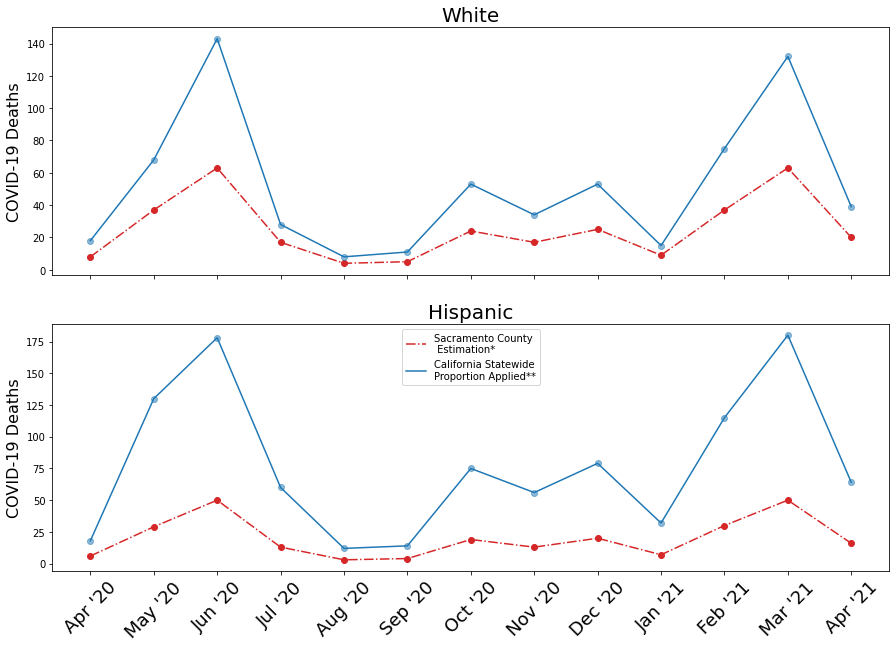

In [ ]:
#Now, we can plot the deaths by racial group by month and compare
#Sacramento's outcomes with respect to proportion as compared to the state level


#NOW, WE CAN PLOT THE DEATHS BY RACIAL GROUP BY MONTH AND COMPARE
#COUNTY OUTCOMES WITH RESPECT TO PROPORTION AS COMPARED TO STATE LEVEL

#FOR SACRAMENTO
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax1.plot(np.arange(0,13),
             sac_race_deaths.White_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax1.scatter(np.arange(0,13),
             sac_race_deaths.White_deaths_est,
             color='tab:red')
ax1.plot(np.arange(0,13),
             sac_race_deaths.CA_White_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax1.scatter(np.arange(0,13),
             sac_race_deaths.CA_White_Deaths,
            color='tab:blue',
            alpha=.5)
ax1.set_xticks(ticks=np.arange(0,13))
ax1.set_xticklabels(ordered_month_year[2:],rotation=90)
ax1.set_title('White',fontsize=20)
ax1.set_ylabel('COVID-19 Deaths',fontsize=16)



ax2.plot(np.arange(0,13),
             sac_race_deaths.Hisp_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax2.scatter(np.arange(0,13),
             sac_race_deaths.Hisp_deaths_est,
            color='tab:red')

ax2.plot(np.arange(0,13),
             sac_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax2.scatter(np.arange(0,13),
             sac_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            alpha=.5)
ax2.set_xticks(ticks=np.arange(0,13))
ax2.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax2.set_title('Hispanic',fontsize=20)
ax2.set_ylabel('COVID-19 Deaths',fontsize=16)

ax2.legend();
#plt.savefig('Sac_WhiteHispanic.png',bbox_inches='tight')

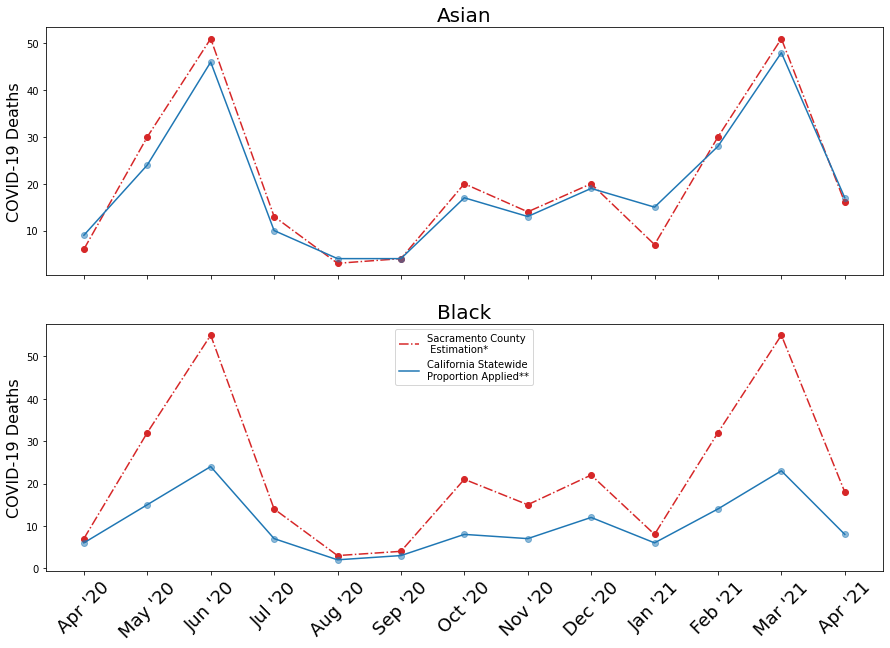

In [ ]:
figb, (ax3,ax4) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax3.plot(np.arange(0,13),
             sac_race_deaths.Asian_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax3.scatter(np.arange(0,13),
             sac_race_deaths.Asian_deaths_est,
             color='tab:red')
ax3.plot(np.arange(0,13),
             sac_race_deaths.CA_Asian_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax3.scatter(np.arange(0,13),
             sac_race_deaths.CA_Asian_Deaths,
            color='tab:blue',
            alpha=.5)
ax3.set_xticks(ticks=np.arange(0,13))
ax3.set_xticklabels(ordered_month_year[2:],rotation=90)
ax3.set_title('Asian',fontsize=20)
ax3.set_ylabel('COVID-19 Deaths',fontsize=16)



ax4.plot(np.arange(0,13),
             sac_race_deaths.Black_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax4.scatter(np.arange(0,13),
             sac_race_deaths.Black_deaths_est,
            color='tab:red')

ax4.plot(np.arange(0,13),
             sac_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax4.scatter(np.arange(0,13),
             sac_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            alpha=.5)
ax4.set_xticks(ticks=np.arange(0,13))
ax4.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax4.set_title('Black',fontsize=20)
ax4.set_ylabel('COVID-19 Deaths',fontsize=16)

ax4.legend();
#plt.savefig('Sac_AsianBlack.png',bbox_inches='tight')

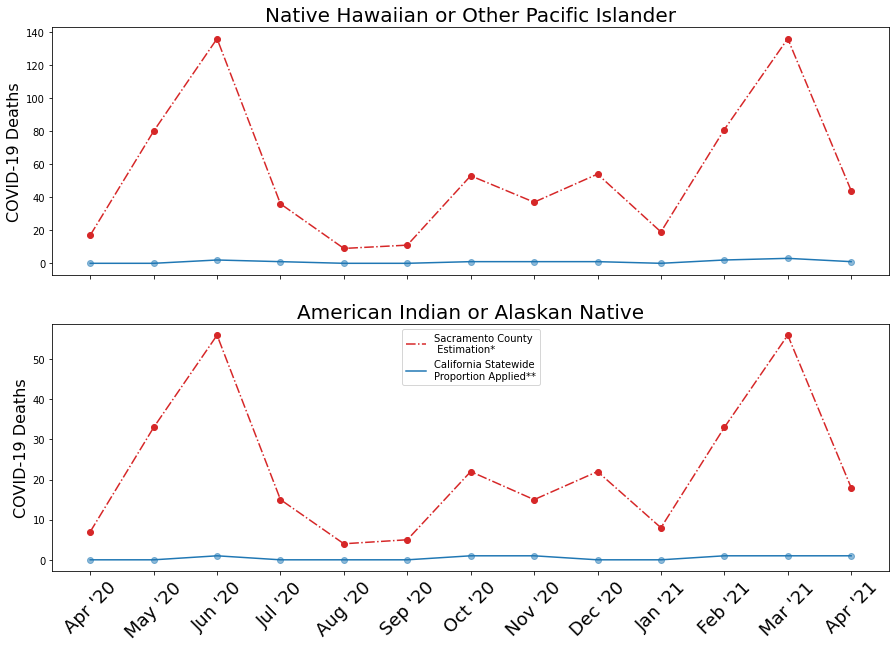

In [ ]:
figc, (ax5,ax6) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax5.plot(np.arange(0,13),
             sac_race_deaths.NHPI_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax5.scatter(np.arange(0,13),
             sac_race_deaths.NHPI_deaths_est,
             color='tab:red')
ax5.plot(np.arange(0,13),
             sac_race_deaths.CA_NHPI_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax5.scatter(np.arange(0,13),
             sac_race_deaths.CA_NHPI_Deaths,
            color='tab:blue',
            alpha=.5)
ax5.set_xticks(ticks=np.arange(0,13))
ax5.set_xticklabels(ordered_month_year[2:],rotation=90)
ax5.set_title('Native Hawaiian or Other Pacific Islander',fontsize=20)
ax5.set_ylabel('COVID-19 Deaths',fontsize=16)



ax6.plot(np.arange(0,13),
             sac_race_deaths.AIAN_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Sacramento County\n Estimation*')
ax6.scatter(np.arange(0,13),
             sac_race_deaths.AIAN_deaths_est,
            color='tab:red')

ax6.plot(np.arange(0,13),
             sac_race_deaths.CA_AIAN_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax6.scatter(np.arange(0,13),
             sac_race_deaths.CA_AIAN_Deaths,
            color='tab:blue',
            alpha=.5)
ax6.set_xticks(ticks=np.arange(0,13))
ax6.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax6.set_title('American Indian or Alaskan Native',fontsize=20)
ax6.set_ylabel('COVID-19 Deaths',fontsize=16)

ax6.legend();
#plt.savefig('Sac_NhpiAian.png',bbox_inches='tight')

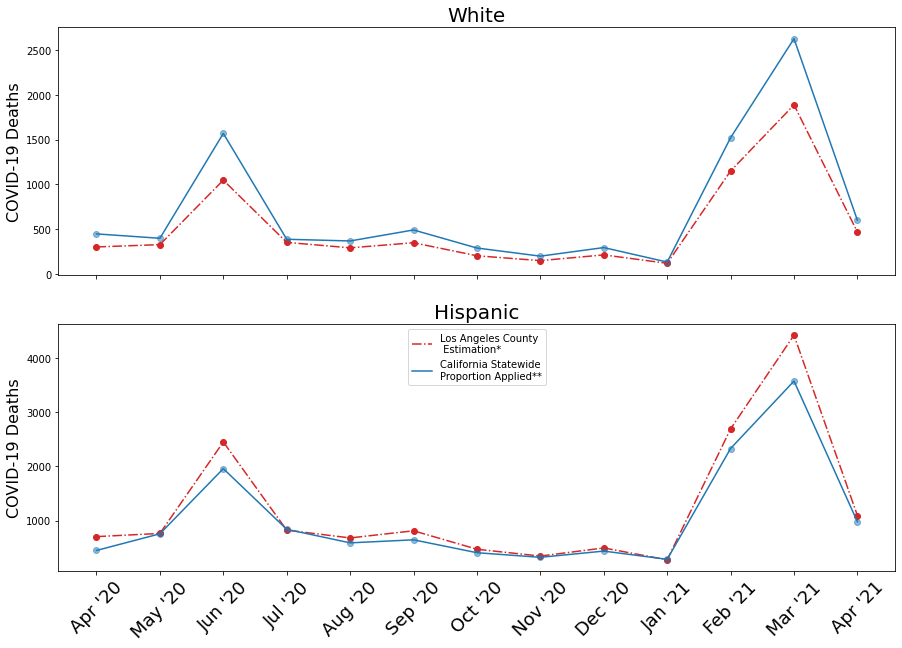

In [ ]:
#FOR LOS ANGELES

fig, (ax1,ax2) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax1.plot(np.arange(0,13),
             la_race_deaths.White_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax1.scatter(np.arange(0,13),
             la_race_deaths.White_deaths_est,
             color='tab:red')
ax1.plot(np.arange(0,13),
             la_race_deaths.CA_White_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax1.scatter(np.arange(0,13),
             la_race_deaths.CA_White_Deaths,
            color='tab:blue',
            alpha=.5)
ax1.set_xticks(ticks=np.arange(0,13))
ax1.set_xticklabels(ordered_month_year[2:],rotation=90)
ax1.set_title('White',fontsize=20)
ax1.set_ylabel('COVID-19 Deaths',fontsize=16)



ax2.plot(np.arange(0,13),
             la_race_deaths.Hisp_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax2.scatter(np.arange(0,13),
             la_race_deaths.Hisp_deaths_est,
            color='tab:red')

ax2.plot(np.arange(0,13),
             la_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax2.scatter(np.arange(0,13),
             la_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            alpha=.5)
ax2.set_xticks(ticks=np.arange(0,13))
ax2.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax2.set_title('Hispanic',fontsize=20)
ax2.set_ylabel('COVID-19 Deaths',fontsize=16)

ax2.legend(loc='upper center');
#plt.savefig('LA_WhiteHispanic.png',bbox_inches='tight')

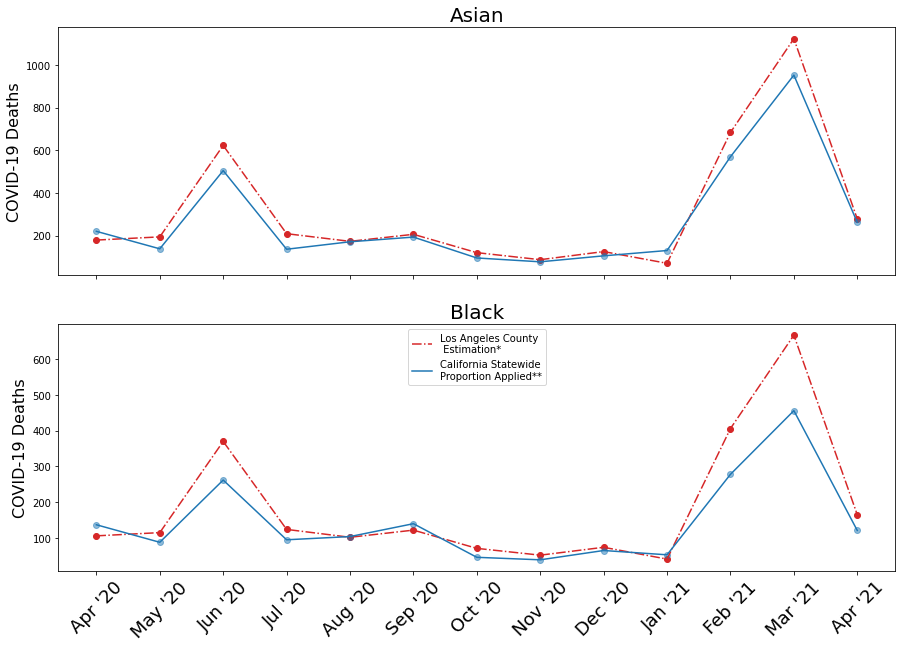

In [ ]:
figb, (ax3,ax4) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax3.plot(np.arange(0,13),
             la_race_deaths.Asian_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax3.scatter(np.arange(0,13),
             la_race_deaths.Asian_deaths_est,
             color='tab:red')
ax3.plot(np.arange(0,13),
             la_race_deaths.CA_Asian_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax3.scatter(np.arange(0,13),
             la_race_deaths.CA_Asian_Deaths,
            color='tab:blue',
            alpha=.5)
ax3.set_xticks(ticks=np.arange(0,13))
ax3.set_xticklabels(ordered_month_year[2:],rotation=90)
ax3.set_title('Asian',fontsize=20)
ax3.set_ylabel('COVID-19 Deaths',fontsize=16)



ax4.plot(np.arange(0,13),
             la_race_deaths.Black_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax4.scatter(np.arange(0,13),
             la_race_deaths.Black_deaths_est,
            color='tab:red')

ax4.plot(np.arange(0,13),
             la_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax4.scatter(np.arange(0,13),
             la_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            alpha=.5)
ax4.set_xticks(ticks=np.arange(0,13))
ax4.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax4.set_title('Black',fontsize=20)
ax4.set_ylabel('COVID-19 Deaths',fontsize=16)

ax4.legend(loc='upper center');
#plt.savefig('LA_AsianBlack.png',bbox_inches='tight')

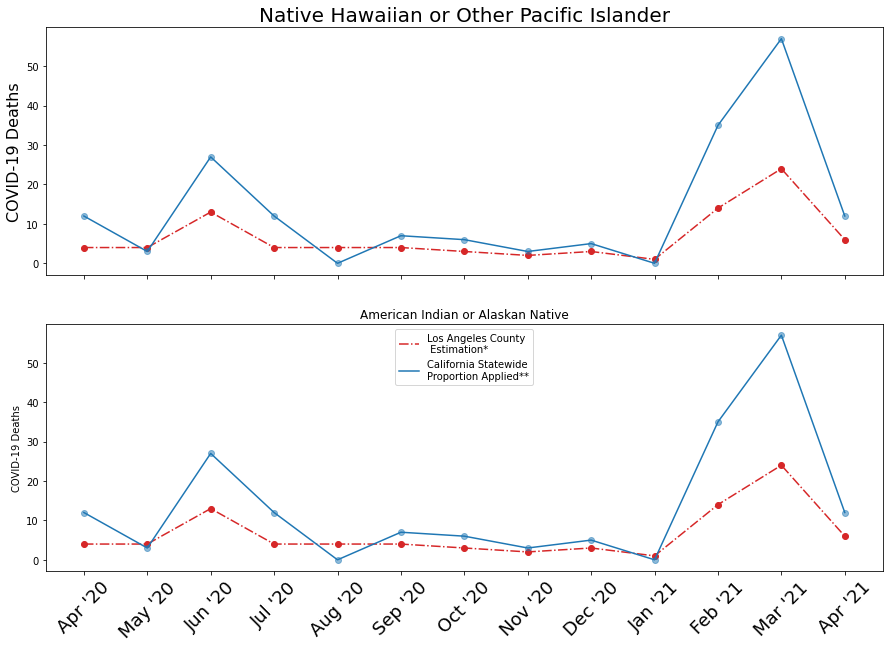

In [ ]:
figc, (ax5,ax6) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax5.plot(np.arange(0,13),
             la_race_deaths.NHPI_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax5.scatter(np.arange(0,13),
             la_race_deaths.NHPI_deaths_est,
             color='tab:red')
ax5.plot(np.arange(0,13),
             la_race_deaths.CA_NHPI_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax5.scatter(np.arange(0,13),
             la_race_deaths.CA_NHPI_Deaths,
            color='tab:blue',
            alpha=.5)
ax5.set_xticks(ticks=np.arange(0,13))
ax5.set_xticklabels(ordered_month_year[2:],rotation=90)
ax5.set_title('Native Hawaiian or Other Pacific Islander',fontsize=20)
ax5.set_ylabel('COVID-19 Deaths',fontsize=16)



ax6.plot(np.arange(0,13),
             la_race_deaths.NHPI_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Los Angeles County\n Estimation*')
ax6.scatter(np.arange(0,13),
             la_race_deaths.NHPI_deaths_est,
            color='tab:red')
ax6.plot(np.arange(0,13),
             la_race_deaths.CA_NHPI_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax6.scatter(np.arange(0,13),
             la_race_deaths.CA_NHPI_Deaths,
            color='tab:blue',
            alpha=.5)
ax6.set_xticks(ticks=np.arange(0,13))
ax6.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax6.set_title('American Indian or Alaskan Native')
ax6.set_ylabel('COVID-19 Deaths')

ax6.legend(loc='upper center');
#plt.savefig('LA_NhpiAian.png',bbox_inches='tight')

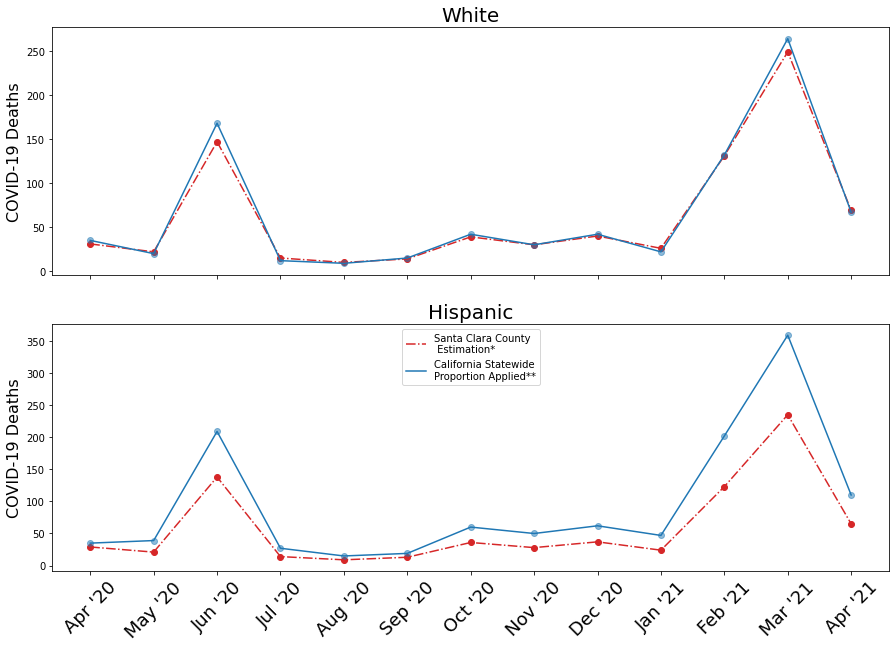

In [ ]:
#FOR SANTA CLARA

fig, (ax1,ax2) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax1.plot(np.arange(0,13),
             sc_race_deaths.White_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Santa Clara County\n Estimation*')
ax1.scatter(np.arange(0,13),
             sc_race_deaths.White_deaths_est,
             color='tab:red')
ax1.plot(np.arange(0,13),
             sc_race_deaths.CA_White_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax1.scatter(np.arange(0,13),
             sc_race_deaths.CA_White_Deaths,
            color='tab:blue',
            alpha=.5)
ax1.set_xticks(ticks=np.arange(0,13))
ax1.set_xticklabels(ordered_month_year[2:],rotation=90)
ax1.set_title('White',fontsize=20)
ax1.set_ylabel('COVID-19 Deaths',fontsize=16)



ax2.plot(np.arange(0,13),
             sc_race_deaths.Hisp_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Santa Clara County\n Estimation*')
ax2.scatter(np.arange(0,13),
             sc_race_deaths.Hisp_deaths_est,
            color='tab:red')

ax2.plot(np.arange(0,13),
             sc_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax2.scatter(np.arange(0,13),
             sc_race_deaths.CA_Hispanic_Deaths,
            color='tab:blue',
            alpha=.5)
ax2.set_xticks(ticks=np.arange(0,13))
ax2.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax2.set_title('Hispanic',fontsize=20)
ax2.set_ylabel('COVID-19 Deaths',fontsize=16)

ax2.legend(loc='upper center');
#plt.savefig('SC_WhiteHispanic.png',bbox_inches='tight')

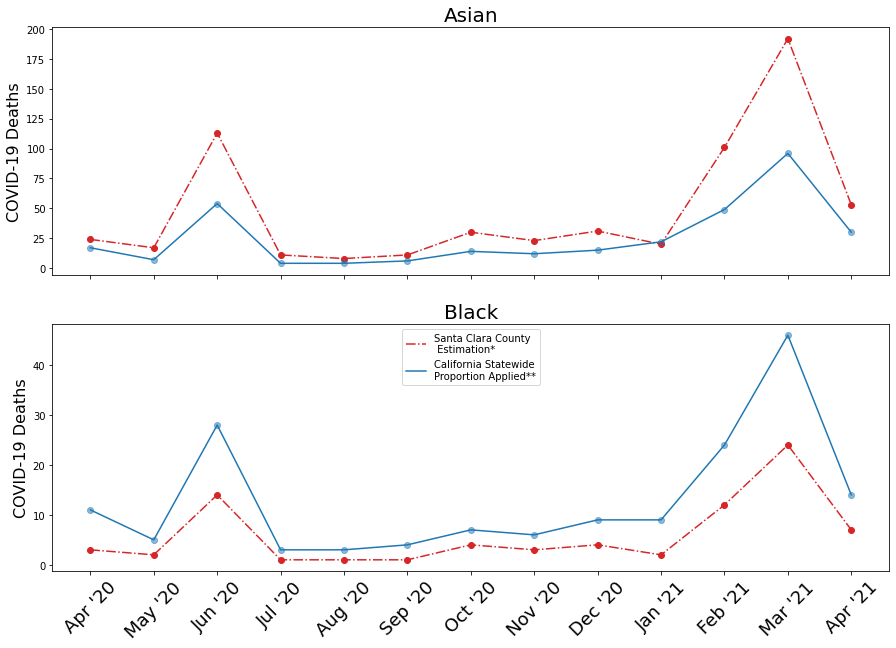

In [ ]:
figb, (ax3,ax4) = plt.subplots(2,sharex=True)
plt.gcf().set_size_inches(15,10)


ax3.plot(np.arange(0,13),
             sc_race_deaths.Asian_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Santa Clara County\n Estimation*')
ax3.scatter(np.arange(0,13),
             sc_race_deaths.Asian_deaths_est,
             color='tab:red')
ax3.plot(np.arange(0,13),
             sc_race_deaths.CA_Asian_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax3.scatter(np.arange(0,13),
             sc_race_deaths.CA_Asian_Deaths,
            color='tab:blue',
            alpha=.5)
ax3.set_xticks(ticks=np.arange(0,13))
ax3.set_xticklabels(ordered_month_year[2:],rotation=90)
ax3.set_title('Asian',fontsize=20)
ax3.set_ylabel('COVID-19 Deaths',fontsize=16)



ax4.plot(np.arange(0,13),
             sc_race_deaths.Black_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Santa Clara County\n Estimation*')
ax4.scatter(np.arange(0,13),
             sc_race_deaths.Black_deaths_est,
            color='tab:red')

ax4.plot(np.arange(0,13),
             sc_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            linestyle='solid',
            label='California Statewide\nProportion Applied**')
ax4.scatter(np.arange(0,13),
             sc_race_deaths.CA_Black_Deaths,
            color='tab:blue',
            alpha=.5)
ax4.set_xticks(ticks=np.arange(0,13))
ax4.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax4.set_title('Black',fontsize=20)
ax4.set_ylabel('COVID-19 Deaths',fontsize=16)

ax4.legend(loc='upper center');
#plt.savefig('SC_AsianBlack.png',bbox_inches='tight')

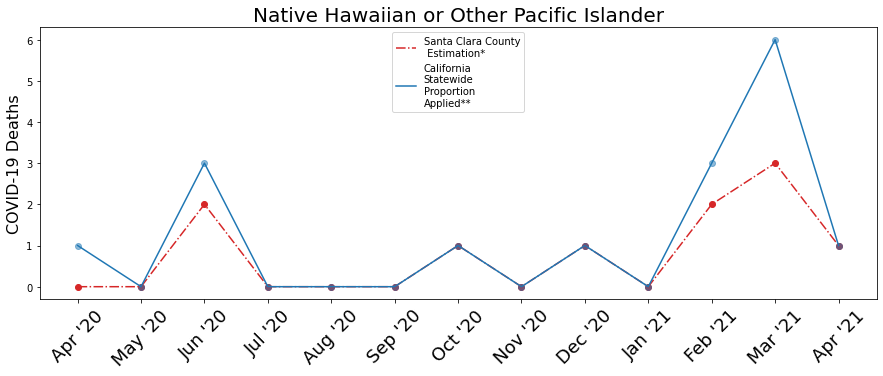

In [ ]:
figc, (ax5) = plt.subplots(1,sharex=True)
plt.gcf().set_size_inches(15,5)


ax5.plot(np.arange(0,13),
             sc_race_deaths.NHPI_deaths_est,
             color='tab:red',
             linestyle='dashdot',
             label='Santa Clara County\n Estimation*')
ax5.scatter(np.arange(0,13),
             sc_race_deaths.NHPI_deaths_est,
             color='tab:red')
ax5.plot(np.arange(0,13),
             sc_race_deaths.CA_NHPI_Deaths,
             color='tab:blue',
             linestyle='solid',
             label='California\nStatewide\nProportion\nApplied**')
ax5.scatter(np.arange(0,13),
             sc_race_deaths.CA_NHPI_Deaths,
            color='tab:blue',
            alpha=.5)
ax5.set_xticks(ticks=np.arange(0,13))
ax5.set_xticklabels(ordered_month_year[2:],rotation=45,fontsize=18)
ax5.set_title('Native Hawaiian or Other Pacific Islander',fontsize=20)
ax5.set_ylabel('COVID-19 Deaths',fontsize=16)

ax5.legend(loc='upper center');
#plt.savefig('SC_NHPI.png',bbox_inches='tight')

In [ ]:
#DATA FOR RACIAL BREAKDOWN OF VACCINES ADMINISTERED
#THIS IS CUMULATIVE DATA AVAILABLE ON A STATE DASHBOARD, 
#SO WE ENTER IT IN MANUALLY.

#WE WISH TO COMPARE THE RACIAL BREAKDOWN OF VACCINES ADMINISTERED 
#IN THE COUNTY AGAINST THAT OF THE STATE AND AGAINST THE PROPORTION OF
#THE COUNTY POPULATION THAT MAKES UP EACH RACIAL CATEGORY

vaxraces=['White','Hispanic','Asian','Black',
          'AIAN','NHPI','Multi-Race','Other','Unknown']
statevaxvalues_race=[.374,.251,.169,.037,.003,.005,.012,.09,.058]
sacvaxvalues_race=[.422,.11,.176,.062,.005,.013,.013,.119,.08]
colusavaxvalues_race=[.338,.381,.01,.005,.009,.002,.006,.056,.194]
lavaxvalues_race=[.291,.324,.17,.053,.002,.004,.015,.109,.032]
scvaxvalues_race=[.292,.151,.4,.017,.002,.006,.013,.072,.047]

#MAKE DATA FRAMES WHERE ROWS ARE RACIAL CATEGORIES,
#COLUMNS ARE COUNTY PERCENTAGES AND STATEWIDE PERCENTAGES

#FOR SACRAMENTO
sacvaxrace_frame=pd.DataFrame(vaxraces,columns=['Race'])
sacvaxrace_frame['Percent_Administered']=sacvaxvalues_race
sacvaxrace_frame['Statewide']=statevaxvalues_race

#FOR COLUSA
colusavaxrace_frame=pd.DataFrame(vaxraces,columns=['Race'])
colusavaxrace_frame['Percent_Administered']=colusavaxvalues_race
colusavaxrace_frame['Statewide']=statevaxvalues_race

#FOR LOS ANGELES
lavaxrace_frame=pd.DataFrame(vaxraces,columns=['Race'])
lavaxrace_frame['Percent_Administered']=lavaxvalues_race
lavaxrace_frame['Statewide']=statevaxvalues_race


#FOR SANTA CLARA
scvaxrace_frame=pd.DataFrame(vaxraces,columns=['Race'])
scvaxrace_frame['Percent_Administered']=scvaxvalues_race
scvaxrace_frame['Statewide']=statevaxvalues_race

In [ ]:
#HERE, WE IMPORT THE COUNTY RACIAL CENSUS DATA, FORMAT IT INTO
#ONE COLUMN FOR THE MOST RECENT YEAR, AND ADD IT TO OUR COUNTY DATA FRAMES

#FOR SACRAMENTO:
#IMPORT CENSUS DATA REGARDING RACES
races_file='Race and Ethnicity.csv'
sac_races=pd.read_csv(races_file)

#SUBSET TO MOST RECENT YEAR & ONLY COLUMNS OF INTEREST
sac_races=sac_races.loc[sac_races.Year==2018]
sac_races=sac_races[['Race','Ethnicity','Population','share']]

#CREATE LIST OF ABBREVIATED RACIAL CATEGORIES TO MATCH
#OTHER PLOTS AND REPLACE THE COLUMN IN CENSUS DATA
list_for_sac_races_race=[]
for i in sac_races.Race.values:
    if 'White' in i:
        list_for_sac_races_race.append('White')
    if 'Black' in i:
        list_for_sac_races_race.append('Black')
    if 'Indian' in i:
        list_for_sac_races_race.append('AIAN')
    if 'Asian' in i:
        list_for_sac_races_race.append('Asian')
    if 'Hawaiian' in i:
        list_for_sac_races_race.append('NHPI')
    if 'Some' in i:
        list_for_sac_races_race.append('Other')
    if 'Two' in i:
        list_for_sac_races_race.append('Multi-Race')
sac_races['Race']=list_for_sac_races_race    

#BECAUSE RACE & ETHNICITY ARE SEPARATE COLUMNS IN THE CENSUS DATA,
#& THERE IS NO LATINO CATEGORY UNDER RACE, BUT LATINO IS PREVALENT
#IN ALL OUR OTHER DATA SETS, WE WILL USE
#[RACE] NON-HISPANIC FOR WHITE, BLACK, ETC, AND WILL GROUP ALL
#[RACE] HISPANIC FOR THE LATINO CATEGORY
#THUS, GROUP BY ETHNICITY (HISPANIC VS NON HISPANIC),
#AND SUM THE POPULATION SHARES OVER THESE CATEGORIES
sac_hispanic_population=sac_races.groupby('Ethnicity').sum()

#WE ONLY NEED THE HISPANIC VALUE, HERE, SO TAKE ONLY THAT VALUE
sac_hispanic_population=[sac_hispanic_population.share.values[0]]

#FOR ALL OTHER CATEGORIES, GRAB THE DATA FROM WHERE ETHNICITY IS NON-HISPANIC
sac_races=list(sac_races.loc[sac_races.Ethnicity=='Not Hispanic or Latino'].share.values)

#Re-order the list and add Hispanic value to match the order of the vaccine data
#add 0 at the end because there is no Unknown data in our Census data
#RE-ORDER THE LIST & ADD HISPANIC VALUE TO MATCH THE ORDER OF THE VACCINE DATA;
#ADD 0 AT THE END BECAUSE THERES NO UNKNOWN VALUE IN OUR CENSUS DATA
sac_races=[sac_races[0],sac_hispanic_population[0],sac_races[3],
          sac_races[1],sac_races[2],sac_races[4],
          sac_races[6],sac_races[5],0]

#ADD THIS COLUMN TO SACRAMENTO'S VACCINE DATA FRAME
sacvaxrace_frame['County_Pop']=sac_races



#NOW, REPEAT THE PROCESS FOR

#COLUSA COUNTY
#IMPORT CENSUS DATA
races_file='Colusa_Race and Ethnicity.csv'
colusa_races=pd.read_csv(races_file)

#SUBSET
colusa_races=colusa_races.loc[colusa_races.Year==2018]
colusa_races=colusa_races[['Race','Ethnicity','Population','share']]

#ABBREVIATE
list_for_colusa_races_race=[]
for i in colusa_races.Race.values:
    if 'White' in i:
        list_for_colusa_races_race.append('White')
    if 'Black' in i:
        list_for_colusa_races_race.append('Black')
    if 'Indian' in i:
        list_for_colusa_races_race.append('AIAN')
    if 'Asian' in i:
        list_for_colusa_races_race.append('Asian')
    if 'Hawaiian' in i:
        list_for_colusa_races_race.append('NHPI')
    if 'Some' in i:
        list_for_colusa_races_race.append('Other')
    if 'Two' in i:
        list_for_colusa_races_race.append('Multi-Race')
colusa_races['Race']=list_for_colusa_races_race    

#CREATE HISPANIC VALUE
colusa_hispanic_population=colusa_races.groupby('Ethnicity').sum()

#GET HISPANIC VALUE
colusa_hispanic_population=[colusa_hispanic_population.share.values[0]]

#GRAB NON-HISPANIC VALUES
colusa_races=list(colusa_races.loc[colusa_races.Ethnicity=='Not Hispanic or Latino'].share.values)

#REORDER LIST
colusa_races=[colusa_races[0],colusa_hispanic_population[0],colusa_races[3],
          colusa_races[1],colusa_races[2],colusa_races[4],
          colusa_races[6],colusa_races[5],0]

#ADD COLUMN TO COLUSA VACCINE DATA FRAME
colusavaxrace_frame['County_Pop']=colusa_races



#FOR LOS ANGELES COUNTY
#IMPORT CENSUS DATA
races_file='LA_Race and Ethnicity.csv'
la_races=pd.read_csv(races_file)

#SUBSET
la_races=la_races.loc[la_races.Year==2018]
la_races=la_races[['Race','Ethnicity','Population','share']]

#ABBREVIATE
list_for_la_races_race=[]
for i in la_races.Race.values:
    if 'White' in i:
        list_for_la_races_race.append('White')
    if 'Black' in i:
        list_for_la_races_race.append('Black')
    if 'Indian' in i:
        list_for_la_races_race.append('AIAN')
    if 'Asian' in i:
        list_for_la_races_race.append('Asian')
    if 'Hawaiian' in i:
        list_for_la_races_race.append('NHPI')
    if 'Some' in i:
        list_for_la_races_race.append('Other')
    if 'Two' in i:
        list_for_la_races_race.append('Multi-Race')
la_races['Race']=list_for_la_races_race    

#CREATE HISPANIC VALUE
la_hispanic_population=la_races.groupby('Ethnicity').sum()

#GRAB HISPANIC VALUE
la_hispanic_population=[la_hispanic_population.share.values[0]]

#GRAB NON HISPANIC VALUES
la_races=list(la_races.loc[la_races.Ethnicity=='Not Hispanic or Latino'].share.values)

#REORDER LIST
la_races=[la_races[0],la_hispanic_population[0],la_races[3],
          la_races[1],la_races[2],la_races[4],
          la_races[6],la_races[5],0]

#ADD COLUMN TO LA COUNTY VACCINE DATA FRAME
lavaxrace_frame['County_Pop']=la_races


#FOR SANTA CLARA COUNTY
#IMPORT CENSUS DATA
races_file='SC_Race and Ethnicity.csv'
sc_races=pd.read_csv(races_file)

#SUBSET
sc_races=sc_races.loc[sc_races.Year==2018]
sc_races=sc_races[['Race','Ethnicity','Population','share']]

#ABBREVIATE
list_for_sc_races_race=[]
for i in sc_races.Race.values:
    if 'White' in i:
        list_for_sc_races_race.append('White')
    if 'Black' in i:
        list_for_sc_races_race.append('Black')
    if 'Indian' in i:
        list_for_sc_races_race.append('AIAN')
    if 'Asian' in i:
        list_for_sc_races_race.append('Asian')
    if 'Hawaiian' in i:
        list_for_sc_races_race.append('NHPI')
    if 'Some' in i:
        list_for_sc_races_race.append('Other')
    if 'Two' in i:
        list_for_sc_races_race.append('Multi-Race')
sc_races['Race']=list_for_sc_races_race    

#CREATE HISPANIC VALUE
sc_hispanic_population=sc_races.groupby('Ethnicity').sum()

#GRAB HISPANIC VALUE
sc_hispanic_population=[sc_hispanic_population.share.values[0]]

#GRAB NON-HISPANIC VALUES
sc_races=list(sc_races.loc[sc_races.Ethnicity=='Not Hispanic or Latino'].share.values)

#REORDER LIST
sc_races=[sc_races[0],sc_hispanic_population[0],sc_races[3],
          sc_races[1],sc_races[2],sc_races[4],
          sc_races[6],sc_races[5],0]

#ADD COLUMN TO SANTA CLARA VACCINE DATA FRAME
scvaxrace_frame['County_Pop']=sc_races

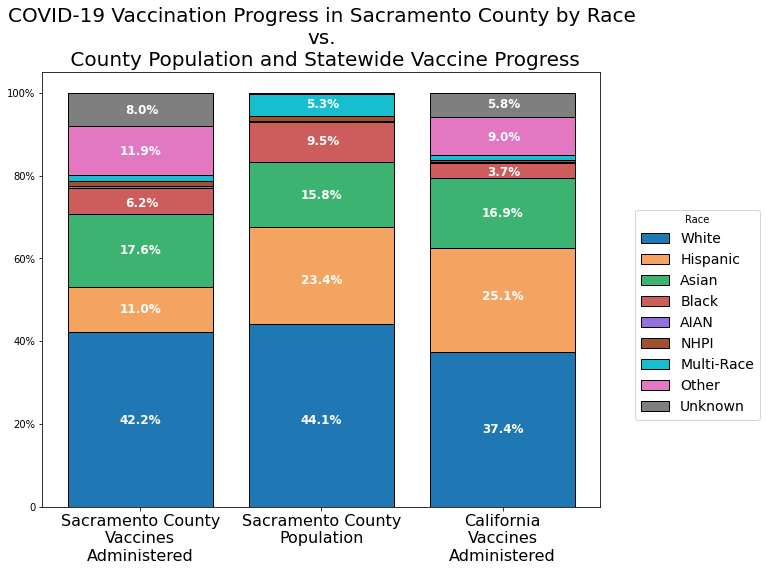

In [ ]:
#NOW WE CAN PLOT THE DISTRIBUTION OF VACCINES BY RACE,
#COMPARING THE COUNTY TO THE STATE, AND THE RACIAL 
#DISTRIBUTION OF VACCINE TO THAT DISTRIBUTION OF A
#COUNTY'S POPULATION

#FIRST, DEFINE A LIST OF COLORS
col_list=['tab:blue','sandybrown','mediumseagreen','indianred','mediumpurple','sienna',
         'tab:cyan','tab:pink','tab:gray']

#FOR SACRAMENTO
b=0
b2=0
b3=0
for i in range(len(sacvaxrace_frame)):
    vax=sacvaxrace_frame['Percent_Administered'].values
    pop=sacvaxrace_frame['County_Pop'].values
    state=sacvaxrace_frame['Statewide'].values
    l=sacvaxrace_frame['Race'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=1)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])
    
#ADD LABELS, MAKE PLOT ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Sacramento County\nVaccines\nAdministered',
                   'Sacramento County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Sacramento County by Race
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Race')

#CREATE DATA LABELS FOR VACCINE DIST & ADD TO PLOT
race_vaxannotations=[]
for i in sacvaxrace_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    race_vaxannotations.append(l)
plt.annotate(race_vaxannotations[0],(.885,.2),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[1],(.885,.4675),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[2],(.885,.61),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[3],(.915,.725),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[7],(.885,.85),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[8],(.915,.95),
            fontsize=12,weight='bold',color='w')

#CREATE DATA LABELS FOR POPULATION & ADD TO PLOT
race_countyannotations=[]
for i in sacvaxrace_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    race_countyannotations.append(l)
plt.annotate(race_countyannotations[0],(1.885,.2),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[1],(1.885,.53875),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[2],(1.885,.745),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[3],(1.915,.875),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[6],(1.915,.9625),
            fontsize=12,weight='bold',color='w')

#CREATE DATA LABELS FOR STATE VACCINES & ADD TO PLOT
race_statevaxannotations=[]
for i in sacvaxrace_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    race_statevaxannotations.append(l)
plt.annotate(race_statevaxannotations[0],(2.885,.18),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[1],(2.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[2],(2.885,.7),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[3],(2.915,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[7],(2.915,.885),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[8],(2.915,.9625),
            fontsize=12,weight='bold',color='w');
#plt.savefig('Sac_Vax_Race.png',bbox_inches='tight')

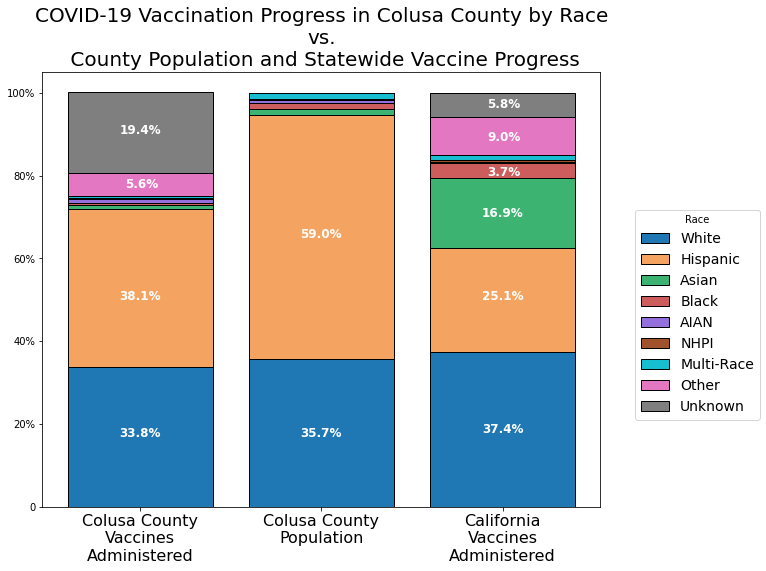

In [ ]:
#REPEAT THE PROCESS FOR COLUSA COUNTY

b=0
b2=0
b3=0
for i in range(len(colusavaxrace_frame)):
    vax=colusavaxrace_frame['Percent_Administered'].values
    pop=colusavaxrace_frame['County_Pop'].values
    state=colusavaxrace_frame['Statewide'].values
    l=colusavaxrace_frame['Race'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=1)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])
    
#ADD LABELS, MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Colusa County\nVaccines\nAdministered',
                   'Colusa County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Colusa County by Race
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Race')

#COUNTY VACCINE DATA LABELS
race_vaxannotations=[]
for i in colusavaxrace_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    race_vaxannotations.append(l)
plt.annotate(race_vaxannotations[0],(.885,.17),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[1],(.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[7],(.915,.77),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[8],(.885,.9),
            fontsize=12,weight='bold',color='w')

#POPULATION DATA LABELS
race_countyannotations=[]
for i in colusavaxrace_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    race_countyannotations.append(l)
plt.annotate(race_countyannotations[0],(1.885,.17),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[1],(1.885,.65),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
race_statevaxannotations=[]
for i in colusavaxrace_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    race_statevaxannotations.append(l)
plt.annotate(race_statevaxannotations[0],(2.885,.18),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[1],(2.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[2],(2.885,.7),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[3],(2.915,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[7],(2.915,.885),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[8],(2.915,.9625),
            fontsize=12,weight='bold',color='w');
#plt.savefig('Colusa_Vax_Race.png',bbox_inches='tight')

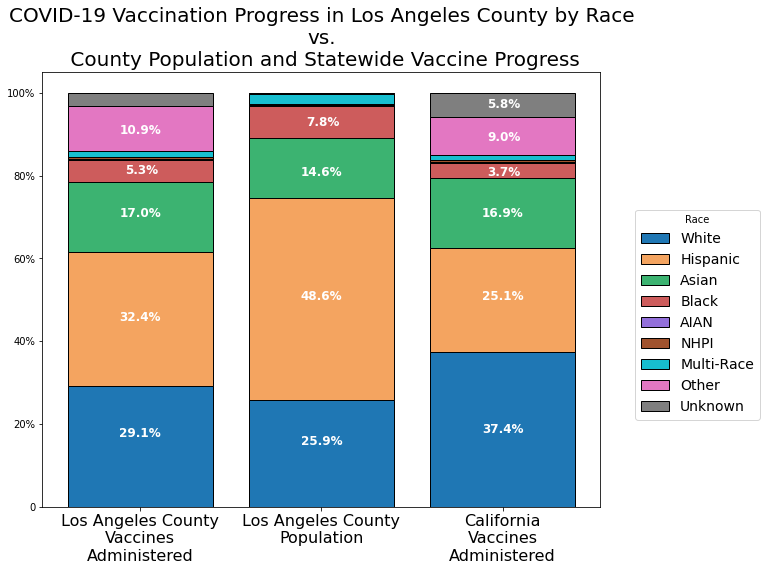

In [ ]:
#REPEAT THE PROCESS FOR LOS ANGELES COUNTY

b=0
b2=0
b3=0
for i in range(len(lavaxrace_frame)):
    vax=lavaxrace_frame['Percent_Administered'].values
    pop=lavaxrace_frame['County_Pop'].values
    state=lavaxrace_frame['Statewide'].values
    l=lavaxrace_frame['Race'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=1)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])
    
#ADD LABELS, MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Los Angeles County\nVaccines\nAdministered',
                   'Los Angeles County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Los Angeles County by Race
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Race')

#COUNTY VACCINE DATA LABELS
race_vaxannotations=[]
for i in lavaxrace_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    race_vaxannotations.append(l)
plt.annotate(race_vaxannotations[0],(.885,.17),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[1],(.885,.45),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[2],(.885,.7),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[3],(.915,.805),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[7],(.8855,.9),
            fontsize=12,weight='bold',color='w')

#POPULATION DATA LABELS
race_countyannotations=[]
for i in lavaxrace_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    race_countyannotations.append(l)
plt.annotate(race_countyannotations[0],(1.885,.15),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[1],(1.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[2],(1.885,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[3],(1.915,.92),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
race_statevaxannotations=[]
for i in lavaxrace_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    race_statevaxannotations.append(l)
plt.annotate(race_statevaxannotations[0],(2.885,.18),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[1],(2.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[2],(2.885,.7),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[3],(2.915,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[7],(2.915,.885),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[8],(2.915,.9625),
            fontsize=12,weight='bold',color='w');
#plt.savefig('LA_Vax_Race.png',bbox_inches='tight')

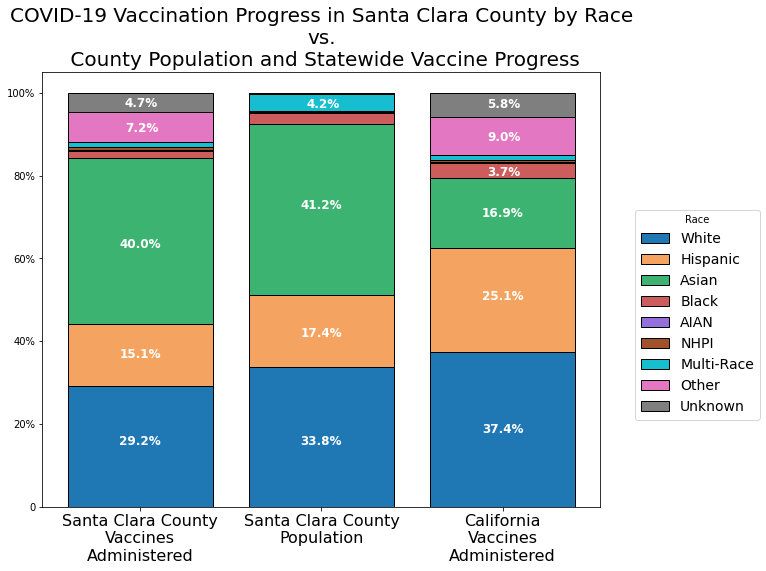

In [ ]:
#REPEAT THE PROCESS FOR SANTA CLARA COUNTY

b=0
b2=0
b3=0
for i in range(len(scvaxrace_frame)):
    vax=scvaxrace_frame['Percent_Administered'].values
    pop=scvaxrace_frame['County_Pop'].values
    state=scvaxrace_frame['Statewide'].values
    l=scvaxrace_frame['Race'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=1)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=1)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])
    
#ADD LABELS, MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Santa Clara County\nVaccines\nAdministered',
                   'Santa Clara County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Santa Clara County by Race
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Race')

#COUNTY VACCINE DATA LABELS
race_vaxannotations=[]
for i in scvaxrace_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    race_vaxannotations.append(l)
plt.annotate(race_vaxannotations[0],(.885,.15),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[1],(.885,.36),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[2],(.885,.625),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[7],(.915,.905),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_vaxannotations[8],(.915,.965),
            fontsize=12,weight='bold',color='w')

#POPULATION DATA LABELS
race_countyannotations=[]
for i in scvaxrace_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    race_countyannotations.append(l)
plt.annotate(race_countyannotations[0],(1.885,.15),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[1],(1.885,.41),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[2],(1.885,.72),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_countyannotations[6],(1.915,.9625),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
race_statevaxannotations=[]
for i in scvaxrace_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    race_statevaxannotations.append(l)
plt.annotate(race_statevaxannotations[0],(2.885,.18),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[1],(2.885,.5),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[2],(2.885,.7),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[3],(2.915,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[7],(2.915,.885),
            fontsize=12,weight='bold',color='w')
plt.annotate(race_statevaxannotations[8],(2.915,.9625),
            fontsize=12,weight='bold',color='w');
#plt.savefig('SC_Vax_Race.png',bbox_inches='tight')

In [ ]:
#DATA FOR AGE GROUP BREAKDOWN OF VACCINES ADMINISTERED
#THIS IS CUMULATIVE DATA AVAILABLE ON A STATE DASHBOARD, 
#SO WE ENTER IT IN MANUALLY.

#WE WISH TO COMPARE THE AGE GROUP BREAKDOWN OF VACCINES ADMINISTERED 
#IN THE COUNTY AGAINST THAT OF THE STATE AND AGAINST THE PROPORTION OF
#THE COUNTY POPULATION THAT MAKES UP EACH AGE GROUP


vaxages=['0-17','18-49','50-64','65+']
statevaxvalues_age=[.017,.46,.264,.259]
sacvaxvalues_age=[.013,.427,.271,.289]
colusavaxvalues_age=[.005,.422,.28,.293]
lavaxvalues_age=[.017,.484,.266,.232]
scvaxvalues_age=[.023,.519,.253,.206]

#MAKE DATA FRAMES WHERE ROWS ARE AGE GROUPS,
#COLUMNS ARE COUNTY PERCENTAGES AND STATEWIDE PERCENTAGES

#FOR SACRAMENTO
sacvaxage_frame=pd.DataFrame(vaxages,columns=['Age'])
sacvaxage_frame['Percent_Administered']=sacvaxvalues_age
sacvaxage_frame['Statewide']=statevaxvalues_age

#FOR COLUSA
colusavaxage_frame=pd.DataFrame(vaxages,columns=['Age'])
colusavaxage_frame['Percent_Administered']=colusavaxvalues_age
colusavaxage_frame['Statewide']=statevaxvalues_age

#FOR LOS ANGELES
lavaxage_frame=pd.DataFrame(vaxages,columns=['Age'])
lavaxage_frame['Percent_Administered']=lavaxvalues_age
lavaxage_frame['Statewide']=statevaxvalues_age


#FOR SANTA CLARA
scvaxage_frame=pd.DataFrame(vaxages,columns=['Age'])
scvaxage_frame['Percent_Administered']=scvaxvalues_age
scvaxage_frame['Statewide']=statevaxvalues_age

In [ ]:
#HERE WE IMPORT SACRAMENTO'S AGE CENSUS DATA & FORMAT
#IT INTO ONE COLUMN OR THE MOST RECENT YEAR

#IMPORT AGE CENSUS DATA
ages_file='Age by Nativity.csv'
sac_ages=pd.read_csv(ages_file)

#SUBSET TO MOST RECENT YEAR & ONLY COLUMNS OF INTEREST
sac_ages=sac_ages.loc[sac_ages.Year==2018]
sac_ages=sac_ages[['Age','share']]

#HERE, THERE ARE 2 ROWS FOR EACH AGE GROUP TO SEPARATE
#DATA FOR THOSE WHO ARE NATIVE-BORN SACRAMENTANS AND THOSE WHO ARE NOT
#WE DONT CARE ABOUT NATIVITY, HERE, THOUGH, SO GROUP BY AGE GROUP
sac_ages=sac_ages.groupby('Age').sum()
sac_ages.reset_index(inplace=True)


#THE AGE GROUPS NEED TO BE GROUPED FURTHER TO MATCH THE VACCINE DATA WE HAVE, 
#WE DO THIS BY REARRANGING THE LIST OF SHARE VALUES BECAUSE THE GROUPS
#ARE IDENTIFIED BY STRINGS AND ARE ALL OUT OF ORDER
short1=sac_ages.share.values
new_age_groups_shares=[short1[4]+short1[10],
                      sum(short1[0:3])+(short1[3]/2),
                      (short1[3]/2)+sum(short1[5:8]),
                      sum(short1[8:10])]


#ADD THIS COLUMN TO THE SACRAMENTO DATA FRAME ABOUT VACCINE AGES
sacvaxage_frame['County_Pop']=new_age_groups_shares



#NOW, REPEAT THE PROCESS


#FOR COLUSA COUNTY:
#IMPORT THE CENSUS AGE DATA
ages_file='Colusa_Age by Nativity.csv'
colusa_ages=pd.read_csv(ages_file)

#SUBSET
colusa_ages=colusa_ages.loc[colusa_ages.Year==2018]
colusa_ages=colusa_ages[['Age','share']]

#GROUP BY AGE GROUP
colusa_ages=colusa_ages.groupby('Age').sum()
colusa_ages.reset_index(inplace=True)

#REARRANGE TO MATCH 
short1=colusa_ages.share.values
new_age_groups_shares=[short1[4]+short1[10],
                      sum(short1[0:3])+(short1[3]/2),
                      (short1[3]/2)+sum(short1[5:8]),
                      sum(short1[8:10])]

#ADD TO COLUSA AGE FRAME
colusavaxage_frame['County_Pop']=new_age_groups_shares



#FOR LOS ANGELES COUNTY:
#IMPORT CENSUS AGE DATA
ages_file='LA_Age by Nativity.csv'
la_ages=pd.read_csv(ages_file)

#SUBSET
la_ages=la_ages.loc[la_ages.Year==2018]
la_ages=la_ages[['Age','share']]

#GROUP BY AGE GROUP
la_ages=la_ages.groupby('Age').sum()
la_ages.reset_index(inplace=True)

#REARRANGE
short1=la_ages.share.values
new_age_groups_shares=[short1[4]+short1[10],
                      sum(short1[0:3])+(short1[3]/2),
                      (short1[3]/2)+sum(short1[5:8]),
                      sum(short1[8:10])]


#ADD TO LA AGE FRAME
lavaxage_frame['County_Pop']=new_age_groups_shares



#FOR SANTA CLARA COUNTY:
#IMPORT CENSUS AGE DATA
ages_file='SC_Age by Nativity.csv'
sc_ages=pd.read_csv(ages_file)

#SUBSET
sc_ages=sc_ages.loc[sc_ages.Year==2018]
sc_ages=sc_ages[['Age','share']]

#GROUP BY AGE GROUP
sc_ages=sc_ages.groupby('Age').sum()
sc_ages.reset_index(inplace=True)

#REARRANGE
short1=sc_ages.share.values
new_age_groups_shares=[short1[4]+short1[10],
                      sum(short1[0:3])+(short1[3]/2),
                      (short1[3]/2)+sum(short1[5:8]),
                      sum(short1[8:10])]


#ADD TO SANTA CLARA AGE FRAME
scvaxage_frame['County_Pop']=new_age_groups_shares

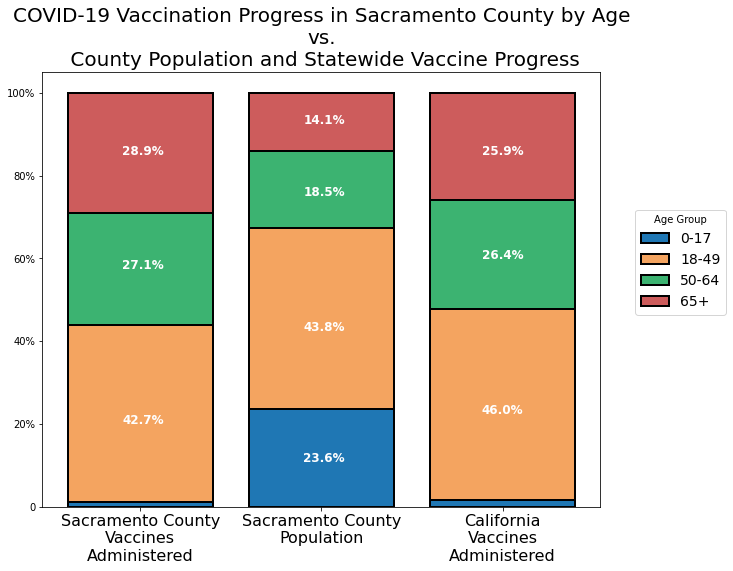

In [ ]:
#NOW WE CAN PLOT THE DISTRIBUTION OF VACCINES BY AGE GROUP,
#COMPARING THE COUNTY TO THE STATE, AND THE AGE GROUP
#DISTRIBUTION OF VACCINE TO THAT DISTRIBUTION OF A
#COUNTY'S POPULATION

#FOR SACRAMENTO COUNTY:
b=0
b2=0
b3=0
for i in range(len(sacvaxage_frame)):
    vax=sacvaxage_frame['Percent_Administered'].values
    pop=sacvaxage_frame['County_Pop'].values
    state=sacvaxage_frame['Statewide'].values
    l=sacvaxage_frame['Age'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=2)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])

#ADD LABELS, MAKE ADJUSTMENTS TO PLOT
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Sacramento County\nVaccines\nAdministered',
                   'Sacramento County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Sacramento County by Age
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Age Group')

#CREATE DATA LABELS FOR COUNTY VACCINE PERCENTAGES & ADD TO PLOT
age_vaxannotations=[]
for i in sacvaxage_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    age_vaxannotations.append(l)
plt.annotate(age_vaxannotations[1],(.9,.2),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[2],(.9,.575),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[3],(.9,.85),
            fontsize=12,weight='bold',color='w') 


#CREATE DATA LABELS FOR POPULATION PERCENTAGES & ADD TO PLOT
age_countyannotations=[]
for i in sacvaxage_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    age_countyannotations.append(l)
plt.annotate(age_countyannotations[0],(1.9,.11),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[1],(1.9,.425),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[2],(1.9,.75),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[3],(1.9,.925),
            fontsize=12,weight='bold',color='w')

#CREATE DATA LABELS FOR STATE VACCINE PERCENTAGES & ADD TO PLOT
age_statevaxannotation=[]
for i in sacvaxage_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    age_statevaxannotation.append(l)
plt.annotate(age_statevaxannotation[1],(2.885,.225),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[2],(2.885,.6),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[3],(2.885,.85),
            fontsize=12,weight='bold',color='w');
#plt.savefig('Sac_Vax_Age.png',bbox_inches='tight')

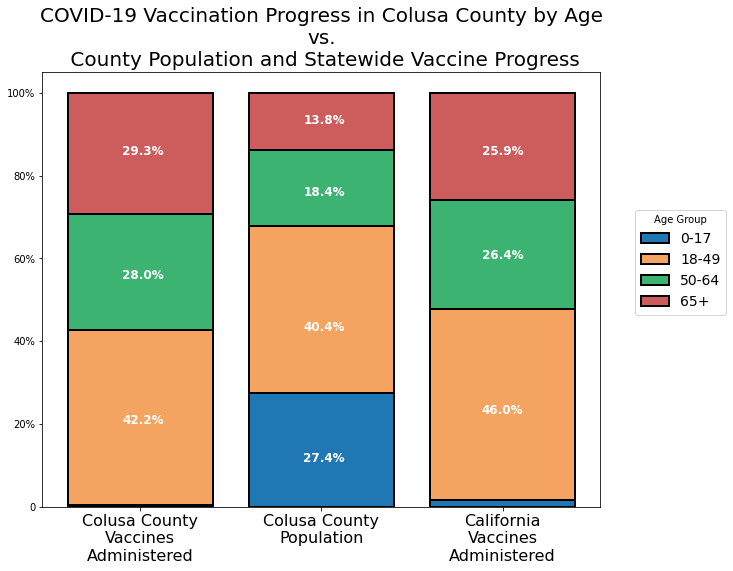

In [ ]:
#REPEAT THE PROCESS FOR COLUSA COUNTY:
b=0
b2=0
b3=0
for i in range(len(colusavaxage_frame)):
    vax=colusavaxage_frame['Percent_Administered'].values
    pop=colusavaxage_frame['County_Pop'].values
    state=colusavaxage_frame['Statewide'].values
    l=colusavaxage_frame['Age'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=2)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])

#ADD LABELS, MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Colusa County\nVaccines\nAdministered',
                   'Colusa County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Colusa County by Age
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Age Group')

#COUNTY VACCINE DATA LABELS
age_vaxannotations=[]
for i in colusavaxage_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    age_vaxannotations.append(l)
plt.annotate(age_vaxannotations[1],(.9,.2),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[2],(.9,.55),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[3],(.9,.85),
            fontsize=12,weight='bold',color='w') 


#POPULATION DATA LABELS
age_countyannotations=[]
for i in colusavaxage_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    age_countyannotations.append(l)
plt.annotate(age_countyannotations[0],(1.9,.11),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[1],(1.9,.425),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[2],(1.9,.75),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[3],(1.9,.925),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
age_statevaxannotation=[]
for i in colusavaxage_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    age_statevaxannotation.append(l)
plt.annotate(age_statevaxannotation[1],(2.885,.225),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[2],(2.885,.6),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[3],(2.885,.85),
            fontsize=12,weight='bold',color='w');
#plt.savefig('Colusa_Vax_Age.png',bbox_inches='tight')

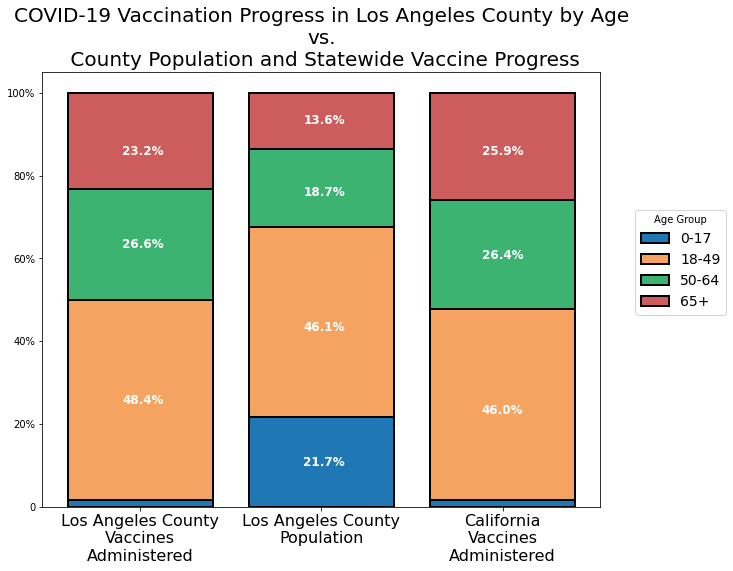

In [ ]:
#REPEAT THE PROCESS FOR LOS ANGELES COUNTY:
b=0
b2=0
b3=0
for i in range(len(lavaxage_frame)):
    vax=lavaxage_frame['Percent_Administered'].values
    pop=lavaxage_frame['County_Pop'].values
    state=lavaxage_frame['Statewide'].values
    l=lavaxage_frame['Age'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=2)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])

#ADD LABELS/MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Los Angeles County\nVaccines\nAdministered',
                   'Los Angeles County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Los Angeles County by Age
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Age Group')

#COUNTY VACCINE DATA LABELS
age_vaxannotations=[]
for i in lavaxage_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    age_vaxannotations.append(l)
plt.annotate(age_vaxannotations[1],(.9,.25),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[2],(.9,.625),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[3],(.9,.85),
            fontsize=12,weight='bold',color='w') 


#POPULATION DATA LABELS
age_countyannotations=[]
for i in lavaxage_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    age_countyannotations.append(l)
plt.annotate(age_countyannotations[0],(1.9,.1),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[1],(1.9,.425),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[2],(1.9,.75),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[3],(1.9,.925),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
age_statevaxannotation=[]
for i in lavaxage_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    age_statevaxannotation.append(l)
plt.annotate(age_statevaxannotation[1],(2.885,.225),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[2],(2.885,.6),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[3],(2.885,.85),
            fontsize=12,weight='bold',color='w');
#plt.savefig('LA_Vax_Age.png',bbox_inches='tight')

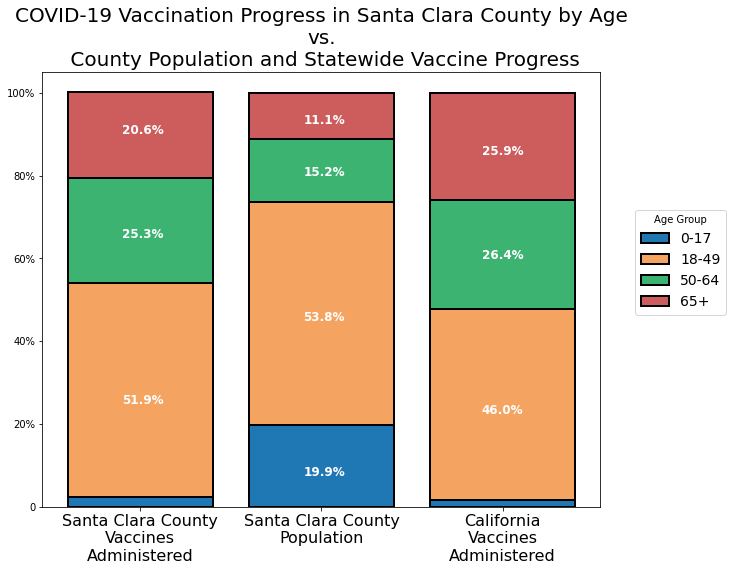

In [ ]:
#REPEAT THE PROCESS FOR SANTA CLARA COUNTY
b=0
b2=0
b3=0
for i in range(len(scvaxage_frame)):
    vax=scvaxage_frame['Percent_Administered'].values
    pop=scvaxage_frame['County_Pop'].values
    state=scvaxage_frame['Statewide'].values
    l=scvaxage_frame['Age'].values[i]
    plt.bar(1,vax[i],bottom=b,label=l,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(2,pop[i],bottom=b2,color=col_list[i],edgecolor='k',linewidth=2)
    plt.bar(3,state[i],bottom=b3,color=col_list[i],edgecolor='k',linewidth=2)
    b=np.add(b,vax[i])
    b2=np.add(b2,pop[i])
    b3=np.add(b3,state[i])

#ADD LABELS/MAKE ADJUSTMENTS
plt.gcf().set_size_inches(10,8)
plt.ylim(top=1.05)
plt.yticks(ticks=[0,.2,.4,.6,.8,1],
          labels=[0,'20%','40%','60%','80%','100%'])
plt.xticks(ticks=[1,2,3],
           labels=['Santa Clara County\nVaccines\nAdministered',
                   'Santa Clara County\nPopulation',
                  'California\nVaccines\nAdministered'],
           fontsize=16)  
plt.title("""COVID-19 Vaccination Progress in Santa Clara County by Age
vs.\n County Population and Statewide Vaccine Progress""",
          fontsize=20)
plt.legend(bbox_to_anchor=(1.05,.7),fontsize=14,title='Age Group')

#COUNTY VACCINE DATA LABELS
age_vaxannotations=[]
for i in scvaxage_frame.Percent_Administered.values:
    l=str(round(100*i,2))+'%'
    age_vaxannotations.append(l)
plt.annotate(age_vaxannotations[1],(.9,.25),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[2],(.9,.65),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_vaxannotations[3],(.9,.9),
            fontsize=12,weight='bold',color='w') 


#POPULATION DATA LABELS
age_countyannotations=[]
for i in scvaxage_frame.County_Pop.values:
    l=str(round(100*i,1))+'%'
    age_countyannotations.append(l)
plt.annotate(age_countyannotations[0],(1.9,.075),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[1],(1.9,.45),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[2],(1.9,.8),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_countyannotations[3],(1.9,.925),
            fontsize=12,weight='bold',color='w')

#STATE VACCINE DATA LABELS
age_statevaxannotation=[]
for i in scvaxage_frame.Statewide.values:
    l=str(round(100*i,1))+'%'
    age_statevaxannotation.append(l)
plt.annotate(age_statevaxannotation[1],(2.885,.225),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[2],(2.885,.6),
            fontsize=12,weight='bold',color='w')
plt.annotate(age_statevaxannotation[3],(2.885,.85),
            fontsize=12,weight='bold',color='w');
#plt.savefig('SC_Vax_Age.png',bbox_inches='tight')

Jacob McGraw's code:

This code is designed to present graphs for various purposes. This code produces a line graph for each of the four couties that our group analyzed for unemployment rates and covid hospitalization rates over time from February 2020 to February 2021. Then, this code produces a scatterplot of Unemployment rates as a function of Hospitalizations. For both plots, the values within the last four months are colored red to indicate that these values occured after the vaccines had been administered. First, the data had to be read in. This was done in the following algorithmic process. For the covid data: 

1. Get and rearrange the data info and put it into its own column.

2. get only the columns of interest and name the years and months appropriately.

3. remove the out of state values from the counties and subset NA values.

4. add a new columns for posotive cases, new reported tests, number of cases, and number of deaths.

5. isolate values other than population to avoid numerical errors in the summation accross groups, resulting in new columns titled thousands of cases, thousands of deaths, and total posotivity rate

5. use this data to assign tier rankings

Now we move on to the unemployment data:

1. read in the data and subset it to a county level, asign the appropriate year, and use the non-seasonally adjusted data.

2. subset the columns of iunterest and then rename for future calculations

3. convert unemployment to percentage

4. add apropriate months and year to the data frame


Now we are able to create the graphs. Before we are able to create the graphs, there is some additional data wrangling and manipulation to get a readable and informative graph.


1. make a list that corresponds the the years and date in the proper order.

2. split the list into pre and post covid vaccine, to signify when the vaccines started to be administered

3. subset the data to a specific county

4. make a column in the covid data that has both the month and year to have the data in a format that matches the unemplotment data

5. use the list of the dates in the corrct order as an index to make a pair of lists that correspond to the covid and unemplopyment data in the proper order in terms of their date.

6. subset the resulting list into pre and post covid status.

Afterwords, plotting the graphs previously mentioned is a fairly easy task.

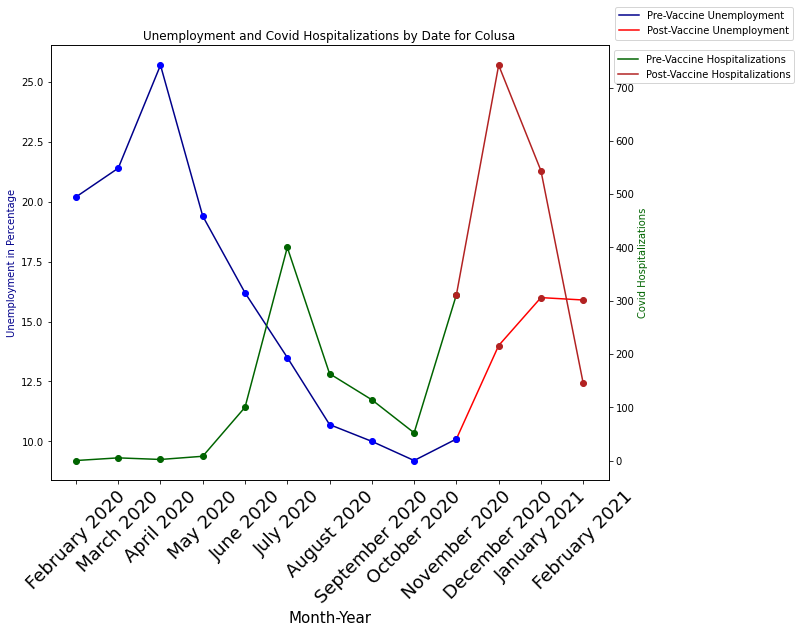

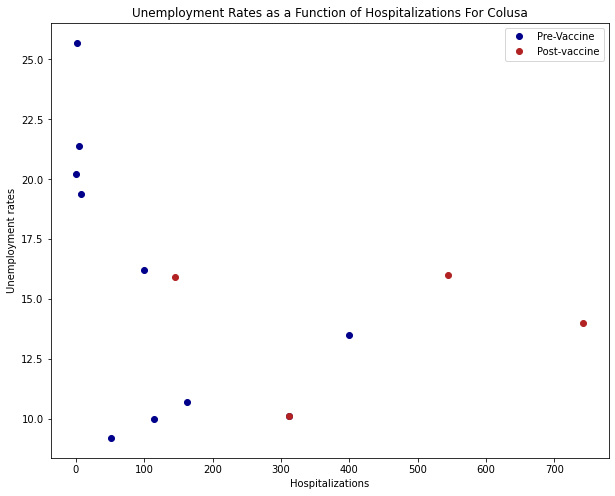

In [ ]:
#First, we will create the algorithm that will read the data into the machine.
#(This code was originally written by fellow group member Jess Herbert)

import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt

#import the Cases/Tests/Deaths Data csv file
cases_file='CA_covid_cases.deaths.tests.csv'
cases=pd.read_csv(cases_file)

#subset to County Level
cases=cases.loc[cases['area_type']=='County']

#Create new date column by rearranging current Date column's values
newdatecol=[]
for i in cases.date.values:
    newdate=str(i[5:])+'-'+str(i[0:4])
    newdatecol.append(newdate)

#Add the new column to the data frame
cases['Date']=newdatecol

#Subset to only columns of interest
cases=cases[['Date','area','population','cases','deaths',
            'total_tests','positive_tests','reported_cases',
            'reported_deaths','reported_tests']]

#Rename columns to shorten names
cases.columns=['Date','County','Pop','Cases','Deaths',
              'Tot_test','Pos_test','Rep_cases',
              'Rep_deaths','Rep_tests']

#The months present in our data are:
month_names=['January','February','March','April','May',
            'June','July','August','September','October',
            'November','December']

#The Years are:
year_names=[2020,2021]

#Make a new column to identify Month
month_col=[]
for i in cases.Date.values:
    if int(i[0:1])==0:
        numeric_month=int(i[1:2])
        month_col.append(month_names[numeric_month-1])
    else:
        numeric_month=int(i[0:2])
        month_col.append(month_names[numeric_month-1])

#Add that column to the data frame
cases['Month']=month_col

#Make a new column to identify Year
year_col=[]
for i in cases.Date.values:
    if int(i[-4:])==year_names[0]:
        year_col.append(year_names[0])
    else:
        year_col.append(year_names[1])

#Add that column to the data frame
cases['Year']=year_col

#Rearrange columns to have the 2 new categorical columns up front
cases=cases[['Year','Month','Date','County','Pop','Cases',
              'Deaths','Tot_test','Pos_test','Rep_cases',
              'Rep_deaths','Rep_tests']]

#Looking at the levels of 'County' we see a few
#values that we want to remove from the analysis
#Filter those rows out
cases=cases[(cases['County']!='Unknown')&(cases['County']!='Out of state')]

#We need to remove missing blank values,
#which are defined as 0 by data dictionary
#that accompanied the dataset 

#Create new columns to remove NaN wherever they are present
#For the 'Cases' column
new_cases=[]
for i in cases.Cases:
    if math.isnan(i):
        new_cases.append(float(0))
    else:
        new_cases.append(i)

#For the 'Deaths' column
new_deaths=[]
for i in cases.Deaths:
    if math.isnan(i):
        new_deaths.append(float(0))
    else:
        new_deaths.append(i)
        
#For 'Total Tests' column
newtot_test=[]
for i in cases.Tot_test:
    if math.isnan(i):
        newtot_test.append(float(0))
    else:
        newtot_test.append(i)

#For 'Positive Tests' column
newpos_test=[]
for i in cases.Pos_test:
    if math.isnan(i):
        newpos_test.append(float(0))
    else:
        newpos_test.append(i)
        
#For 'Reported Tests' column
newrep_test=[]
for i in cases.Rep_tests:
    if math.isnan(i):
        newrep_test.append(float(0))
    else:
        newrep_test.append(i)

#Replace the old columns with the new ones
cases['Cases']=new_cases
cases['Deaths']=new_deaths
cases['Tot_test']=newtot_test
cases['Pos_test']=newpos_test
cases['Rep_tests']=newrep_test

#Based on the data dictionary that accompanied the dataset,
#We need to make a few adjustments to account for the difference
#between Cases & Reported Cases, Deaths & Reported Deaths

#For the number of cases
cleaned_casecol=[]
for i in range(len(cases)):
    a=cases.Cases.values[i]
    b=cases.Rep_cases.values[i]
    m=max(a,b)
    cleaned_casecol.append(m)

#For the number of deaths
cleaned_deathscol=[]
for i in range(len(cases)):
    a=cases.Deaths.values[i]
    b=cases.Rep_deaths.values[i]
    m=max(a,b)
    cleaned_deathscol.append(m)

#Replace old columns with cleaned columns
cases['Cases']=cleaned_casecol
cases['Deaths']=cleaned_deathscol

#Subset to remove old columns
cases=cases[['Year','Month','Date','County','Pop',
           'Cases','Deaths','Tot_test','Pos_test']]
cases.loc[cases.Year==2020]




#Now we are ready to do some calculations
#Before summing cases, deaths, etc over months
#We must isolate population so it doesn't get summed

#Copy the original frame to avoid errors moving forward
countypops=cases.copy(deep=True)
countypops=countypops[['County','Pop']]

#Drop duplicate rows as the popuation is constant
#for a county through our data
countypops.drop_duplicates(keep='first',inplace=True)

#Isolate everything beside population here
cases2=cases.copy(deep=True)
cases2=cases2[['Year','Month','County','Cases','Deaths','Tot_test','Pos_test']]

#Sum across the numeric variables 
cases2=cases2.groupby(['Year','Month','County']).sum()

#Reset the index so month, year, county are still categorical variables
cases2.reset_index(inplace=True)

#merge the two together to reintroduce Population
cases2=pd.merge(countypops,cases2,on='County')

#Calculate RV for Cases as pct of County Pop/month
#rate is per 100k people
case_100k=[]
for i in range(len(cases2)):
    num=cases2.Cases[i]
    den=(cases2.Pop[i]/100000)
    pct=round((num/den),1)
    case_100k.append(pct)

#Calculate RV for Deaths as pct of County Pop/month
#rate is per 100k people
death_100k=[]
for i in range(len(cases2)):
    num=cases2.Deaths[i]
    den=(cases2.Pop[i]/100000)
    pct=round((num/den),1)
    death_100k.append(pct)
    
#Calculate RV for test positivity rate/month
postestrate=[]
for i in range(len(cases2)):
    num=cases2.Pos_test[i]
    den=cases2.Tot_test[i]
    if den==0:
        postestrate.append(0)
    else:
        pct=round(((num/den)*100),3)
        postestrate.append(pct)

#Add new columns for these RV's
cases2['Case_100k']=case_100k
cases2['Death_100k']=death_100k
cases2['Pos_test_rate']=postestrate


#Using CA tiers - assign categorical variable based on Test Positivity Rate:
posrate_tier=[]
for i in range(len(cases2)):
    x=cases2.Pos_test_rate[i]
    t='yellow'
    if (x>=2)&(x<5):
        t='orange'
    elif (x>=5)&(x<=8):
        t='red'
    elif x>8:
        t='purple'
    posrate_tier.append(t)

#Using CA tiers - assign categorical variable based on Number of cases.
cases_tier=[]
for i in range(len(cases2)):
    x=cases2.Case_100k[i]
    t='yellow'
    if (x>=60)&(x<180):
        t='orange'
    elif (x>=180)&(x<=300):
        t='red'
    elif x>300:
        t='purple'
    cases_tier.append(t)

cases2['Tier_posrate']=posrate_tier
cases2['Tier_newcases100k']=cases_tier











##############################################################################
#Next, we will Use a simlilar algorithm to get the Unemployment data.
##############################################################################
#(This code was originally written by fellwo group member Jess Herbert)






#import the Unemployment Data csv file
unemployment_file='CA_Unemployment.csv'
unemployment=pd.read_csv(unemployment_file)

#subset to County-level
unemployment=unemployment.loc[unemployment['Area Type ']=='County']

#remove seasonally adjusted data
unemployment=unemployment.loc[unemployment['Seasonally Adjusted (Y/N) ']=='N']

#subset to only 2020 and 2021
unemployment=unemployment.loc[(unemployment['Year ']==2020)|(unemployment['Year ']==2021)]

#subset to remove columns that are not of interest
unemployment=unemployment[['Area Name ','Date','Year ','Month',
                          'Labor Force','Employment ',
                           'Unemployment ','Unemployment Rate ']]

#rename columns to remove spaces
unemployment.columns=['AreaName','Date','Year','Month',
                     'LaborForce','Employment',
                     'Unemployment','UnemploymentRate']

#remove the word 'County' from each county name
area_names_new=[]
for i in unemployment.AreaName.values:
    name=i[:-7]
    area_names_new.append(name)

#replace the original column with these updated names
unemployment['AreaName']=area_names_new

#Convert Unemployment Rates to standard percentages for later
unemployment_rates_new=[]
for i in unemployment.UnemploymentRate.values:
    rate=round((i*100),1)
    unemployment_rates_new.append(rate)

#replace original column with new updated rates
unemployment.UnemploymentRate=unemployment_rates_new

#reset index so it runs from 0,1,...
unemployment.reset_index(inplace=True)

#remove filtered index column
unemployment=unemployment[['AreaName','Date','Year','Month',
                     'LaborForce','Employment',
                     'Unemployment','UnemploymentRate']]

#The months present in our data are:
month_names=['January','February','March','April','May',
            'June','July','August','September','October',
            'November','December']

#The Years are:
year_names=[2020,2021]

#Create RV to combine Month and Year columns into a single column
monthandyear=[]
for i in month_names:
    if i in month_names[0:2]:
        for j in year_names:
            monthandyear.append(i+' '+str(j))
    else:
        monthandyear.append(i+' '+str(year_names[0]))

#Each of CA's 58 counties has a row for each of the month/year combos
#so we make a new column where each Month,Year is added 58 times
monthandyear_col=[]
for i in monthandyear:
    partialcol=[i]*58
    monthandyear_col=monthandyear_col+partialcol

#Add the new column to our data frame
unemployment['Month_Year']=monthandyear_col

#Remove the Month and Year columns
unemployment=unemployment[['AreaName','Date','Month_Year',
                     'LaborForce','Employment',
                     'Unemployment','UnemploymentRate']]









#################################################################################
##Analysis of Colusa County Covid cases  vs unemployment rates 
#################################################################################


#Data To Use:
#    cases2-data for cases
#    unemployment-data for unemployment


#one of the ways we will siplay the relationship between these two variables is with a
#excellent way to establish a visual relationship between multiple variables.


co_covid=cases2[cases2.County=='Colusa']

co_unemployment=unemployment[unemployment.AreaName=='Colusa']





#create a list that corresponds to the ordered months that appear in each dataset
my_x_axis=['February 2020','March 2020','April 2020','May 2020'\
          ,'June 2020','July 2020','August 2020','September 2020','October 2020'\
          ,'November 2020','December 2020','January 2021','February 2021']


#Subsect the data that is pre and post hospitolizations 
x_axis_p_1=my_x_axis[:10]
x_axis_p_2=my_x_axis[9:]


#create lists that will store the data for plotting
my_employment_axis=[]
my_covid_axis=[]


#creates an index that we will use to combine the month and year
my_i_values=list(co_covid.index.values)


#creates a list that will hold the year and month for labeling purpuses
real_year=[]


#goes through each value and concatenated the year and month
for i in my_i_values:
    real_year.append(co_covid.loc[i].Month + ' ' + repr(co_covid.loc[i].Year))
    

#makes a new column for the the year and month 
co_covid.insert(13,'real_year',real_year)


#This code gets the appropriate values from the dataframe according to the year value
for i in my_x_axis:
    my_covid_axis.append(co_covid[co_covid.real_year==i].Cases.values[0])
    my_employment_axis.append(co_unemployment[\
            co_unemployment.Month_Year==i].UnemploymentRate.values[0])
    

    
#fills in the corresponding values for pre and post vaccine
my_covid_axis_p1=my_covid_axis[:10]
my_covid_axis_p2=my_covid_axis[9:]
my_employment_axis_p1=my_employment_axis[:10]
my_employment_axis_p2=my_employment_axis[9:]

    

#Now to plot the data:

########################
#LINE GRAPH
########################


#create our plot objects
fig, ax1 = plt.subplots()


#set the size
plt.gcf().set_size_inches(10,8)


ax1.plot(np.arange(len(x_axis_p_1)),my_employment_axis_p1, label='Pre-Vaccine Unemployment',color='darkblue')
ax1.plot([9,10,11,12],my_employment_axis_p2,label='Post-Vaccine Unemployment',c='r')
ax1.plot([9,10,11,12],my_employment_axis_p2,'o',color='firebrick')
ax1.plot(np.arange(len(my_covid_axis_p1)),my_employment_axis_p1,'ob')
plt.xticks(np.arange(len(my_x_axis)),my_x_axis,rotation=45,fontsize=18)
ax1.set_xlabel('Month-Year',fontsize=15)
ax1.set_ylabel('Unemployment in Percentage',c='darkblue')
ax1.set_title("Unemployment and Covid Hospitalizations by Date for Colusa")
ax1.legend(bbox_to_anchor=(1.34,1.1))

ax2 = ax1.twinx()

ax2.plot(np.arange(len(x_axis_p_1)), my_covid_axis_p1,c='darkgreen',label='Pre-Vaccine Hospitalizations')
ax2.plot(np.arange(len(x_axis_p_1)),my_covid_axis_p1,'o',color='darkgreen')
ax2.plot([9,10,11,12], my_covid_axis_p2,c='firebrick',label='Post-Vaccine Hospitalizations')
ax2.plot([9,10,11,12],my_covid_axis_p2,'o',color='firebrick')
ax2.set_ylabel('Covid Hospitalizations',c='darkgreen');
ax2.legend(bbox_to_anchor=(1,1));

#plt.savefig('Unemployment and Covid Hospitolizations by Date',format='jpg')




########################
#SCATTERPLOT
########################

#Another way to find a possible relationship between the two variables is with a scatterplot
#thankfully, this relationship is much easier to plot, and will be much nicer if we use
#two sepperate plots as opposed to one plot, due to the discrepency in the size of the units


fig = plt.figure()
ax = plt.axes()


#set the size
plt.gcf().set_size_inches(10,8)


ax.plot(my_covid_axis_p1,my_employment_axis_p1,'o',label='Pre-Vaccine',color='darkblue')
ax.plot(my_covid_axis_p2,my_employment_axis_p2,'o',label='Post-vaccine',color='firebrick')
ax.set_title('Unemployment Rates as a Function of Hospitalizations For Colusa')
ax.set_xlabel('Hospitalizations')
ax.set_ylabel('Unemployment rates')
ax.legend();

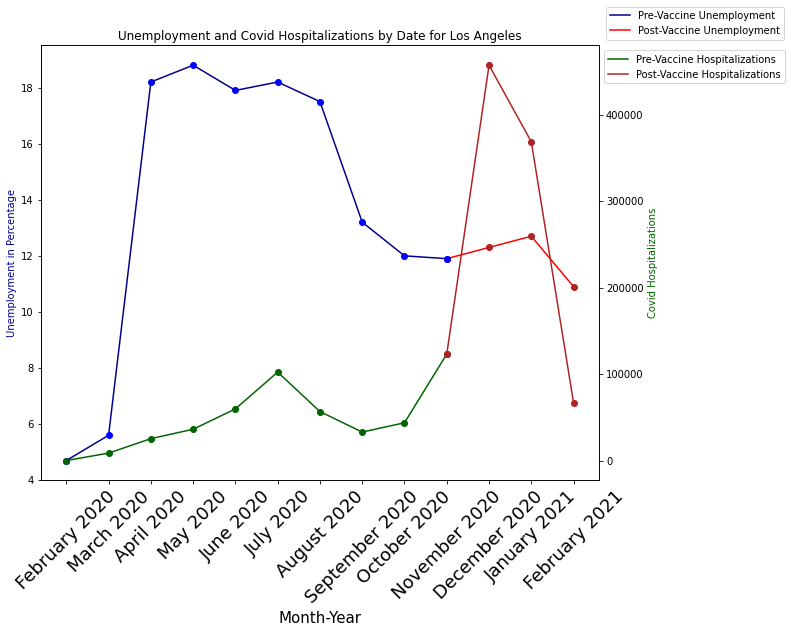

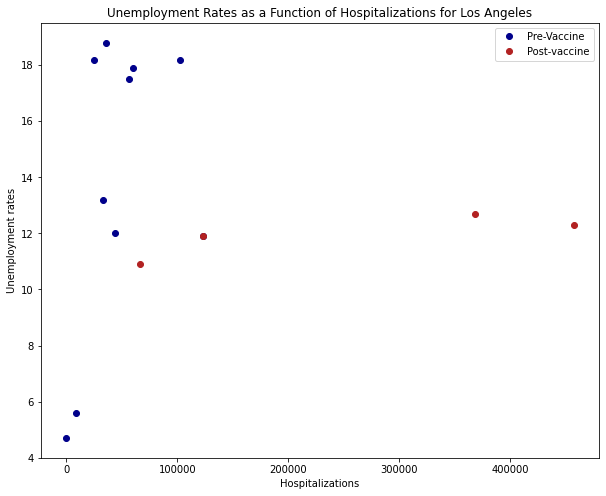

In [ ]:

#################################################################################
##Analysis of Los Angeles County Covid cases  vs unemployment rates 
#################################################################################


#Data To Use:
#    cases2-data for cases
#    unemployment-data for unemployment


#one of the ways we will siplay the relationship between these two variables is with a
#excellent way to establish a visual relationship between multiple variables.


#subset the unemployment data to Los Angeles
LA_unemployed_data=unemployment[unemployment.AreaName=='Los Angeles']


#create a list that corresponds to the ordered months that appear in each dataset
my_x_axis=['February 2020','March 2020','April 2020','May 2020'\
          ,'June 2020','July 2020','August 2020','September 2020','October 2020'\
          ,'November 2020','December 2020','January 2021','February 2021']


#Subsect the data that is pre and post hospitolizations 
x_axis_p_1=my_x_axis[:10]
x_axis_p_2=my_x_axis[9:]


#create lists that will store the data for plotting
my_employment_axis=[]
my_covid_axis=[]


#subset the covid data to Los Angeles
LA_covid_data=cases2[cases2.County=='Los Angeles']


#creates an index that we will use to combine the month and year
my_i_values=list(LA_covid_data.index.values)


#creates a list that will hold the year and month for labeling purpuses
real_year=[]


#goes through each value and concatenated the year and month
for i in my_i_values:
    real_year.append(LA_covid_data.loc[i].Month + ' ' + repr(LA_covid_data.loc[i].Year))
    

#makes a new column for the the year and month 
LA_covid_data.insert(13,'real_year',real_year)


#This code gets the appropriate values from the dataframe according to the year value
for i in my_x_axis:
    my_covid_axis.append(LA_covid_data[LA_covid_data.real_year==i].Cases.values[0])
    my_employment_axis.append(LA_unemployed_data[\
            LA_unemployed_data.Month_Year==i].UnemploymentRate.values[0])
      

#fills in the corresponding values for pre and post vaccine
my_covid_axis_p1=my_covid_axis[:10]
my_covid_axis_p2=my_covid_axis[9:]
my_employment_axis_p1=my_employment_axis[:10]
my_employment_axis_p2=my_employment_axis[9:]


#Now to plot the data:

########################
#LINE GRAPH
########################


#create our plot objects
fig, ax1 = plt.subplots()


#set the size
plt.gcf().set_size_inches(10,8)


ax1.plot(np.arange(len(x_axis_p_1)),my_employment_axis_p1, label='Pre-Vaccine Unemployment',color='darkblue')
ax1.plot([9,10,11,12],my_employment_axis_p2,label='Post-Vaccine Unemployment',c='r')
ax1.plot([9,10,11,12],my_employment_axis_p2,'o',color='firebrick')
ax1.plot(np.arange(len(my_covid_axis_p1)),my_employment_axis_p1,'ob')
plt.xticks(np.arange(len(my_x_axis)),my_x_axis,rotation=45,fontsize=18)
ax1.set_xlabel('Month-Year',fontsize=15)
ax1.set_ylabel('Unemployment in Percentage',c='darkblue')
ax1.set_title("Unemployment and Covid Hospitalizations by Date for Los Angeles")
ax1.legend(bbox_to_anchor=(1.34,1.1))

ax2 = ax1.twinx()

ax2.plot(np.arange(len(x_axis_p_1)), my_covid_axis_p1,c='darkgreen',label='Pre-Vaccine Hospitalizations')
ax2.plot(np.arange(len(x_axis_p_1)),my_covid_axis_p1,'o',color='darkgreen')
ax2.plot([9,10,11,12], my_covid_axis_p2,c='firebrick',label='Post-Vaccine Hospitalizations')
ax2.plot([9,10,11,12],my_covid_axis_p2,'o',color='firebrick')
ax2.set_ylabel('Covid Hospitalizations',c='darkgreen');
ax2.legend(bbox_to_anchor=(1,1));

#plt.savefig('Unemployment and Covid Hospitolizations by Date',format='jpg')




########################
#SCATTERPLOT
########################

#Another way to find a possible relationship between the two variables is with a scatterplot
#thankfully, this relationship is much easier to plot, and will be much nicer if we use
#two sepperate plots as opposed to one plot, due to the discrepency in the size of the units


fig = plt.figure()
ax = plt.axes()


#set the size
plt.gcf().set_size_inches(10,8)


ax.plot(my_covid_axis_p1,my_employment_axis_p1,'o',label='Pre-Vaccine',color='darkblue')
ax.plot(my_covid_axis_p2,my_employment_axis_p2,'o',label='Post-vaccine',color='firebrick')
ax.set_title('Unemployment Rates as a Function of Hospitalizations for Los Angeles')
ax.set_xlabel('Hospitalizations')
ax.set_ylabel('Unemployment rates')
ax.legend();

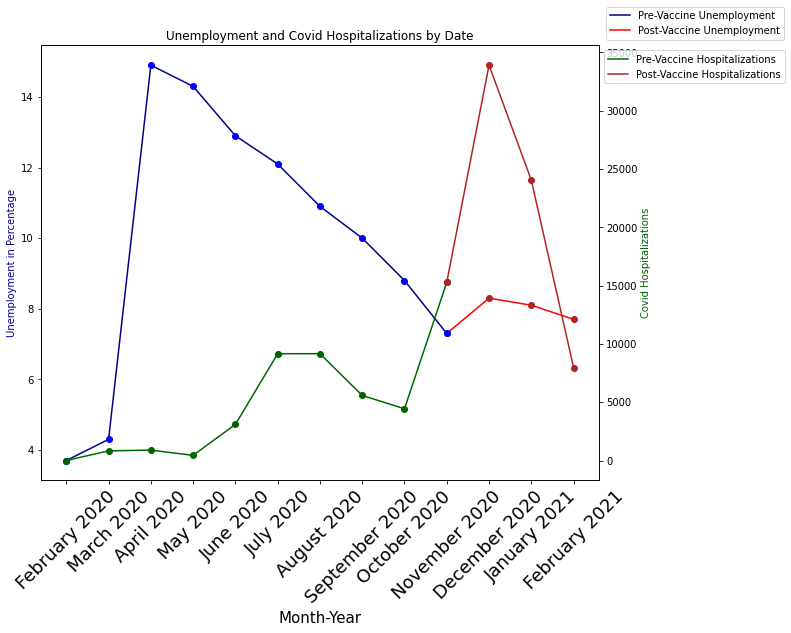

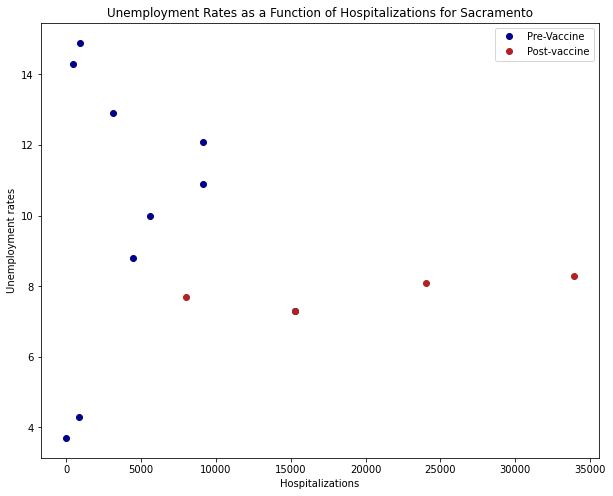

In [ ]:

#################################################################################
##Analysis of Sacramento County Covid cases  vs unemployment rates 
#################################################################################


#Data To Use:
#    cases2-data for cases
#    unemployment-data for unemployment


#one of the ways we will siplay the relationship between these two variables is with a
#excellent way to establish a visual relationship between multiple variables.




#Now that we have the data properly imported into python ,we can begin forming graphs 
#and performing exploratory analysis. 

sa_covid=cases2[cases2.County=='Sacramento']


sa_unemployment=unemployment[unemployment.AreaName=='Sacramento']


#create a list that corresponds to the ordered months that appear in each dataset
my_x_axis=['February 2020','March 2020','April 2020','May 2020'\
          ,'June 2020','July 2020','August 2020','September 2020','October 2020'\
          ,'November 2020','December 2020','January 2021','February 2021']


#Subsect the data that is pre and post hospitolizations 
x_axis_p_1=my_x_axis[:10]
x_axis_p_2=my_x_axis[9:]


#create lists that will store the data for plotting
my_employment_axis=[]
my_covid_axis=[]

#creates an index that we will use to combine the month and year
my_i_values=list(sa_covid.index.values)


#creates a list that will hold the year and month for labeling purpuses
real_year=[]


#goes through each value and concatenated the year and month
for i in my_i_values:
    real_year.append(sa_covid.loc[i].Month + ' ' + repr(sa_covid.loc[i].Year))
    

#makes a new column for the the year and month 
sa_covid.insert(13,'real_year',real_year)


#This code gets the appropriate values from the dataframe according to the year value
for i in my_x_axis:
    my_covid_axis.append(sa_covid[sa_covid.real_year==i].Cases.values[0])
    my_employment_axis.append(sa_unemployment[\
            sa_unemployment.Month_Year==i].UnemploymentRate.values[0])
    

    

#fills in the corresponding values for pre and post vaccine
my_covid_axis_p1=my_covid_axis[:10]
my_covid_axis_p2=my_covid_axis[9:]
my_employment_axis_p1=my_employment_axis[:10]
my_employment_axis_p2=my_employment_axis[9:]

    

#Now to plot the data:

########################
#LINE GRAPH
########################


#create our plot objects
fig, ax1 = plt.subplots()


#set the size
plt.gcf().set_size_inches(10,8)


ax1.plot(np.arange(len(x_axis_p_1)),my_employment_axis_p1, label='Pre-Vaccine Unemployment',color='darkblue')
ax1.plot([9,10,11,12],my_employment_axis_p2,label='Post-Vaccine Unemployment',c='r')
ax1.plot([9,10,11,12],my_employment_axis_p2,'o',color='firebrick')
ax1.plot(np.arange(len(my_covid_axis_p1)),my_employment_axis_p1,'ob')
plt.xticks(np.arange(len(my_x_axis)),my_x_axis,rotation=45,fontsize=18)
ax1.set_xlabel('Month-Year',fontsize=15)
ax1.set_ylabel('Unemployment in Percentage',c='darkblue')
ax1.set_title("Unemployment and Covid Hospitalizations by Date")
ax1.legend(bbox_to_anchor=(1.34,1.1))

ax2 = ax1.twinx()

ax2.plot(np.arange(len(x_axis_p_1)), my_covid_axis_p1,c='darkgreen',label='Pre-Vaccine Hospitalizations')
ax2.plot(np.arange(len(x_axis_p_1)),my_covid_axis_p1,'o',color='darkgreen')
ax2.plot([9,10,11,12], my_covid_axis_p2,c='firebrick',label='Post-Vaccine Hospitalizations')
ax2.plot([9,10,11,12],my_covid_axis_p2,'o',color='firebrick')
ax2.set_ylabel('Covid Hospitalizations',c='darkgreen');
ax2.legend(bbox_to_anchor=(1,1));

#plt.savefig('Unemployment and Covid Hospitolizations by Date',format='jpg')




########################
#SCATTERPLOT
########################

#Another way to find a possible relationship between the two variables is with a scatterplot
#thankfully, this relationship is much easier to plot, and will be much nicer if we use
#two sepperate plots as opposed to one plot, due to the discrepency in the size of the units


fig = plt.figure()
ax = plt.axes()


#set the size
plt.gcf().set_size_inches(10,8)


ax.plot(my_covid_axis_p1,my_employment_axis_p1,'o',label='Pre-Vaccine',color='darkblue')
ax.plot(my_covid_axis_p2,my_employment_axis_p2,'o',label='Post-vaccine',color='firebrick')
ax.set_title('Unemployment Rates as a Function of Hospitalizations for Sacramento')
ax.set_xlabel('Hospitalizations')
ax.set_ylabel('Unemployment rates')
ax.legend();

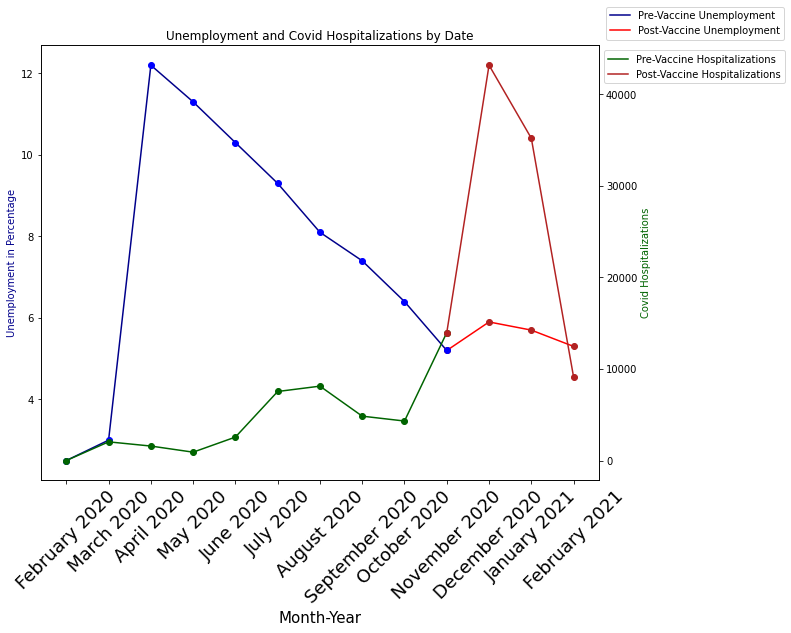

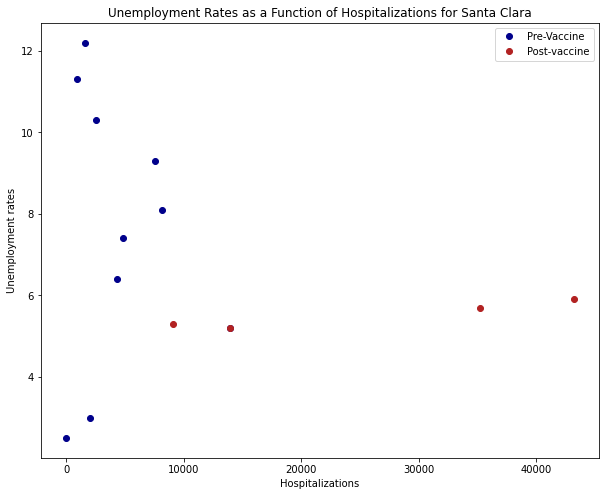

In [ ]:
#################################################################################
##Analysis of Santa Clara County Covid cases  vs unemployment rates 
#################################################################################


#Data To Use:
#    cases2-data for cases
#    unemployment-data for unemployment


#one of the ways we will siplay the relationship between these two variables is with a
#excellent way to establish a visual relationship between multiple variables.




#create a list that corresponds to the ordered months that appear in each dataset
my_x_axis=['February 2020','March 2020','April 2020','May 2020'\
          ,'June 2020','July 2020','August 2020','September 2020','October 2020'\
          ,'November 2020','December 2020','January 2021','February 2021']


#Subsect the data that is pre and post hospitolizations 
x_axis_p_1=my_x_axis[:10]
x_axis_p_2=my_x_axis[9:]


#create lists that will store the data for plotting
my_employment_axis=[]
my_covid_axis=[]


#santa clara covid data
s_c_covid=cases2[cases2.County=='Santa Clara']



s_c_unemployment=unemployment[unemployment.AreaName=='Santa Clara']


my_i_values=list(s_c_covid.index.values)

#creates a list that will hold the year and month for labeling purpuses
real_year=[]


#goes through each value and concatenated the year and month

for i in my_i_values:
    real_year.append(s_c_covid.loc[i].Month + ' ' + repr(s_c_covid.loc[i].Year))
    

#makes a new column for the the year and month 
s_c_covid.insert(13,'real_year',real_year)


    
#This code gets the appropriate values from the dataframe according to the year value
for i in my_x_axis:
    my_covid_axis.append(s_c_covid[s_c_covid.real_year==i].Cases.values[0])
    my_employment_axis.append(s_c_unemployment[\
            s_c_unemployment.Month_Year==i].UnemploymentRate.values[0])
    

    
    
#fills in the corresponding values for pre and post vaccine
my_covid_axis_p1=my_covid_axis[:10]
my_covid_axis_p2=my_covid_axis[9:]
my_employment_axis_p1=my_employment_axis[:10]
my_employment_axis_p2=my_employment_axis[9:]

    

#Now to plot the data:

########################
#LINE GRAPH
########################


#create our plot objects
fig, ax1 = plt.subplots()


#set the size
plt.gcf().set_size_inches(10,8)


ax1.plot(np.arange(len(x_axis_p_1)),my_employment_axis_p1, label='Pre-Vaccine Unemployment',color='darkblue')
ax1.plot([9,10,11,12],my_employment_axis_p2,label='Post-Vaccine Unemployment',c='r')
ax1.plot([9,10,11,12],my_employment_axis_p2,'o',color='firebrick')
ax1.plot(np.arange(len(my_covid_axis_p1)),my_employment_axis_p1,'ob')
plt.xticks(np.arange(len(my_x_axis)),my_x_axis,rotation=45,fontsize=18)
ax1.set_xlabel('Month-Year',fontsize=15)
ax1.set_ylabel('Unemployment in Percentage',c='darkblue')
ax1.set_title("Unemployment and Covid Hospitalizations by Date")
ax1.legend(bbox_to_anchor=(1.34,1.1))

ax2 = ax1.twinx()

ax2.plot(np.arange(len(x_axis_p_1)), my_covid_axis_p1,c='darkgreen',label='Pre-Vaccine Hospitalizations')
ax2.plot(np.arange(len(x_axis_p_1)),my_covid_axis_p1,'o',color='darkgreen')
ax2.plot([9,10,11,12], my_covid_axis_p2,c='firebrick',label='Post-Vaccine Hospitalizations')
ax2.plot([9,10,11,12],my_covid_axis_p2,'o',color='firebrick')
ax2.set_ylabel('Covid Hospitalizations',c='darkgreen');
ax2.legend(bbox_to_anchor=(1,1));

#plt.savefig('Unemployment and Covid Hospitolizations by Date',format='jpg')




########################
#SCATTERPLOT
########################

#Another way to find a possible relationship between the two variables is with a scatterplot
#thankfully, this relationship is much easier to plot, and will be much nicer if we use
#two sepperate plots as opposed to one plot, due to the discrepency in the size of the units


fig = plt.figure()
ax = plt.axes()


#set the size
plt.gcf().set_size_inches(10,8)


ax.plot(my_covid_axis_p1,my_employment_axis_p1,'o',label='Pre-Vaccine',color='darkblue')
ax.plot(my_covid_axis_p2,my_employment_axis_p2,'o',label='Post-vaccine',color='firebrick')
ax.set_title('Unemployment Rates as a Function of Hospitalizations for Santa Clara')
ax.set_xlabel('Hospitalizations')
ax.set_ylabel('Unemployment rates')
ax.legend();

Diana Valderrama's Code

The code below displays:
* Vaccination Rates in the counties of Los Angeles, Santa Clara, Sacramento, and Colusa by age group

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

file = 'COVID-19 Vaccines Administered By Demographics.csv'
vax_by_demo = pd.read_csv(file)

# create a data frame where the demographic
# that is being focused on is the age group
age = vax_by_demo[vax_by_demo.demographic_category == 'Age Group']

# restrict the data frame to the columns that are wanted
age = age[['county', 'demographic_value', 'administered_date', 'partially_vaccinated', 'fully_vaccinated']]

# rename columns to be more meaningful
age = age.rename(columns = {'demographic_value': 'age_range', 'administered_date': 'date',  
                            'partially_vaccinated': 'group_partially_vaxed', 
                            'fully_vaccinated': 'group_fully_vaxed'})

# create a new column that adds the partial and full vaccinations for a group on a given day
age['group_vaxed_day_total'] = age['group_partially_vaxed'] + age['group_fully_vaxed']

#restrict the data only to each county
age_c = age[age.county == 'Colusa']
age_la = age[age.county == 'Los Angeles']
age_s = age[age.county == 'Sacramento']
age_sc = age[age.county == 'Santa Clara']

# create a relationship between the date and age range
df_c = age_c.groupby(['date', 'age_range']).sum()
df_la = age_la.groupby(['date', 'age_range']).sum()
df_s = age_s.groupby(['date', 'age_range']).sum()
df_sc = age_sc.groupby(['date', 'age_range']).sum()

# only focus on the daily vaccine totals
group_vax_c = df_c[['group_vaxed_day_total']]
group_vax_la = df_la[['group_vaxed_day_total']]
group_vax_s = df_s[['group_vaxed_day_total']]
group_vax_sc = df_sc[['group_vaxed_day_total']]

# reset the index 
gv_c = group_vax_c.reset_index(inplace=False)
gv_la = group_vax_la.reset_index(inplace=False)
gv_s = group_vax_s.reset_index(inplace=False)
gv_sc = group_vax_sc.reset_index(inplace=False)

# make the age range the index so we can aggregate over age groups
gv_c.set_index(['age_range'], inplace = True)
gv_la.set_index(['age_range'], inplace = True)
gv_s.set_index(['age_range'], inplace = True)
gv_sc.set_index(['age_range'], inplace = True)

# create a data frame for each age group in each county
low_c = gv_c.loc['0-17']
mid_low_c = gv_c.loc['18-49']
mid_up_c = gv_c.loc['50-64']
up_c = gv_c.loc['65+']

low_la = gv_la.loc['0-17']
mid_low_la = gv_la.loc['18-49']
mid_up_la = gv_la.loc['50-64']
up_la = gv_la.loc['65+']

low_s = gv_s.loc['0-17']
mid_low_s = gv_s.loc['18-49']
mid_up_s = gv_s.loc['50-64']
up_s = gv_s.loc['65+']

low_sc = gv_sc.loc['0-17']
mid_low_sc = gv_sc.loc['18-49']
mid_up_sc = gv_sc.loc['50-64']
up_sc = gv_sc.loc['65+']

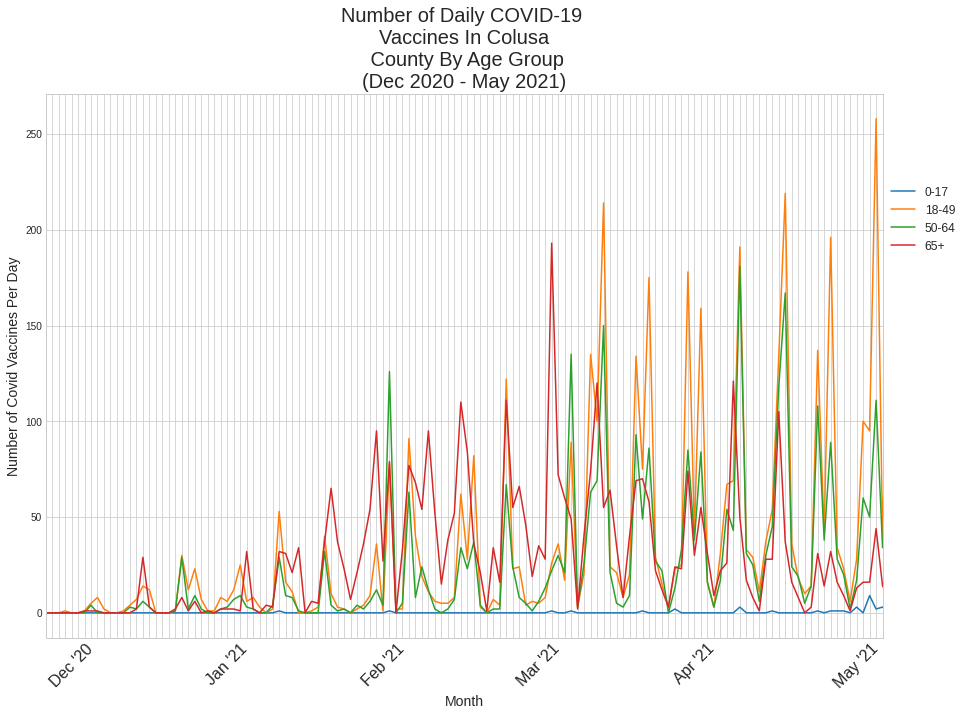

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

# create lines for each age group and add labels 
ax.plot(low_c.date, low_c.group_vaxed_day_total, label = '0-17')
ax.plot(mid_low_c.date, mid_low_c.group_vaxed_day_total, label = '18-49')
ax.plot(mid_up_c.date, mid_up_c.group_vaxed_day_total, label = '50-64')
ax.plot(up_c.date, up_c.group_vaxed_day_total, label = '65+')

# add title and axes labels
plt.title("Number of Daily COVID-19 \nVaccines In Colusa\n County By Age Group\
\n(Dec 2020 - May 2021)",fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Number of Covid Vaccines Per Day", fontsize = 14)

# create a legend
plt.legend(bbox_to_anchor = (1.1,0.85), fontsize = 12)

# reset and label the x-axis ticks to reflect the months accurately
plt.xlim(0,129)
plt.xticks(ticks = ())
months = ('','','','',"Dec '20",'','','','','','','','','', '','','','','','','','','','','',
          '','','',"Jan '21",'','','','','','','','','','','','','','','','','','','','','',
          '','',"Feb '21",'','','','','','','','','','','','','','','','','','','','','','',
          '',"Mar '21",'','','','','','','','','','','','','','','','','','','','','','','', 
          "Apr '21",'','','','','','','','','','','','','','','','','','','','','','','','',
          "May '21",'','','','')
plt.xticks(ticks=np.arange(0,130),labels = months,rotation = 45,fontsize = 16)

# resize the graph
plt.gcf().set_size_inches(15,10);

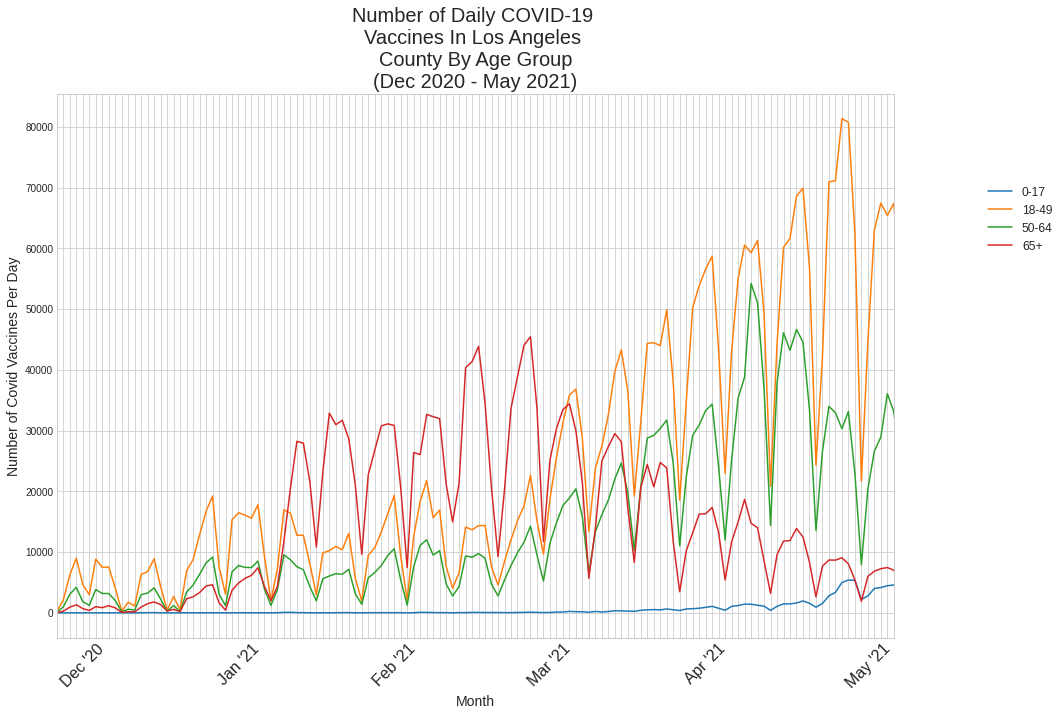

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

# create lines for each age group and add labels 
ax.plot(low_la.date, low_la.group_vaxed_day_total, label = '0-17')
ax.plot(mid_low_la.date, mid_low_la.group_vaxed_day_total, label = '18-49')
ax.plot(mid_up_la.date, mid_up_la.group_vaxed_day_total, label = '50-64')
ax.plot(up_la.date, up_la.group_vaxed_day_total, label = '65+')

# add title and axes labels
plt.title("Number of Daily COVID-19 \nVaccines In Los Angeles \nCounty By Age Group\
\n(Dec 2020 - May 2021)", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Number of Covid Vaccines Per Day", fontsize = 14)

# create a legend
plt.legend(bbox_to_anchor = (1.1,0.85), fontsize = 12)

# reset and label the x-axis ticks to reflect the months accurately
plt.xlim(0,129)
plt.xticks(ticks = ())
months = ('','','','',"Dec '20",'','','','','','','','','', '','','','','','','','','','','',
          '','','',"Jan '21",'','','','','','','','','','','','','','','','','','','','','',
          '','',"Feb '21",'','','','','','','','','','','','','','','','','','','','','','',
          '',"Mar '21",'','','','','','','','','','','','','','','','','','','','','','','', 
          "Apr '21",'','','','','','','','','','','','','','','','','','','','','','','','',
          "May '21",'','','','')
plt.xticks(ticks=np.arange(0,130),labels = months,rotation = 45,fontsize = 16)

# resize the graph
plt.gcf().set_size_inches(15,10);

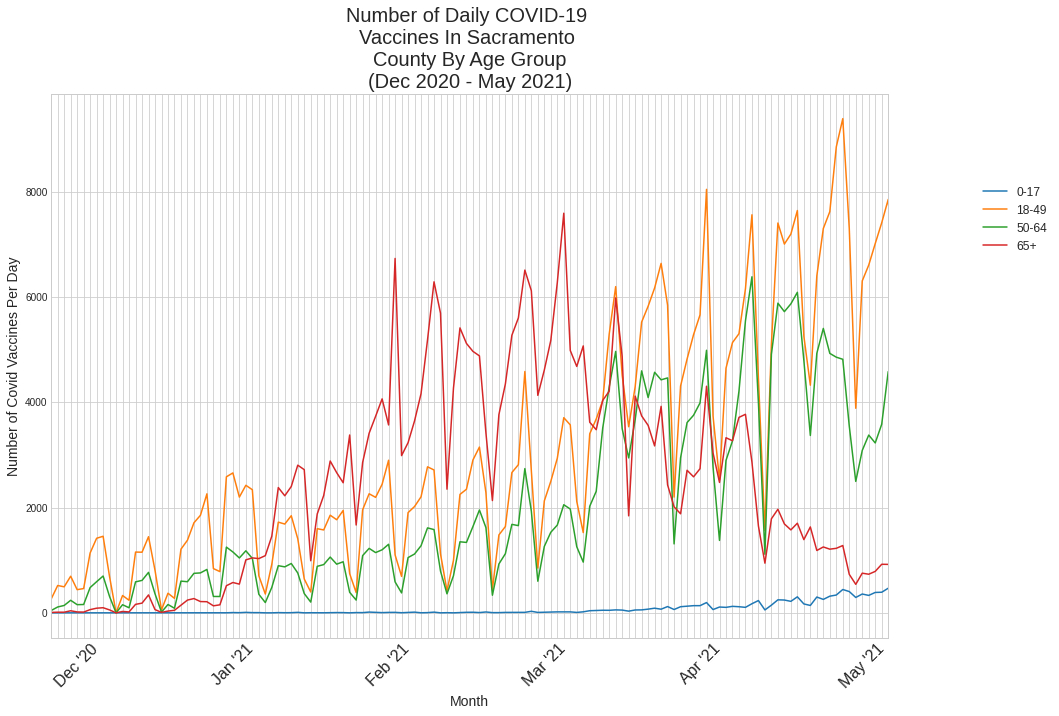

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

# create lines for each age group and add labels 
ax.plot(low_s.date, low_s.group_vaxed_day_total, label = '0-17')
ax.plot(mid_low_s.date, mid_low_s.group_vaxed_day_total, label = '18-49')
ax.plot(mid_up_s.date, mid_up_s.group_vaxed_day_total, label = '50-64')
ax.plot(up_s.date, up_s.group_vaxed_day_total, label = '65+')

# add title and axes labels
plt.title("Number of Daily COVID-19 \nVaccines In Sacramento \nCounty By Age Group\
\n(Dec 2020 - May 2021)", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Number of Covid Vaccines Per Day", fontsize = 14)

# create a legend
plt.legend(bbox_to_anchor = (1.1,0.85), fontsize = 12)

# reset and label the x-axis ticks to reflect the months accurately
plt.xlim(0,129)
plt.xticks(ticks = ())
months = ('','','','',"Dec '20",'','','','','','','','','', '','','','','','','','','','','',
          '','','',"Jan '21",'','','','','','','','','','','','','','','','','','','','','',
          '','',"Feb '21",'','','','','','','','','','','','','','','','','','','','','','',
          '',"Mar '21",'','','','','','','','','','','','','','','','','','','','','','','', 
          "Apr '21",'','','','','','','','','','','','','','','','','','','','','','','','',
          "May '21",'','','','')
plt.xticks(ticks=np.arange(0,130),labels = months,rotation = 45,fontsize = 16)

# resize the graph
plt.gcf().set_size_inches(15,10);

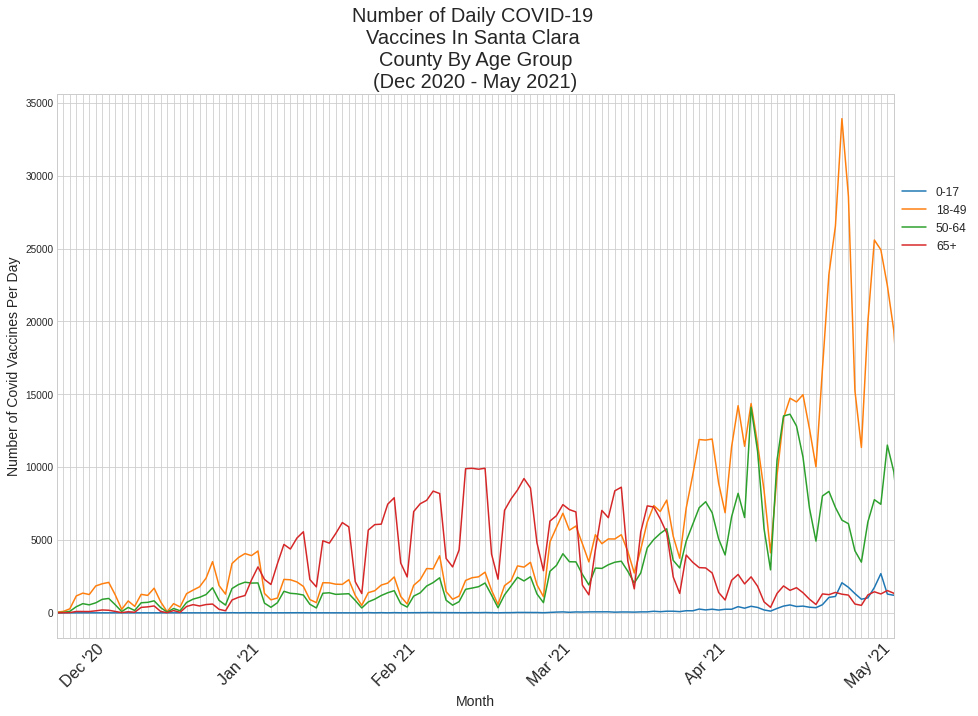

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()

# create lines for each age group and add labels 
ax.plot(low_sc.date, low_sc.group_vaxed_day_total, label = '0-17')
ax.plot(mid_low_sc.date, mid_low_sc.group_vaxed_day_total, label = '18-49')
ax.plot(mid_up_sc.date, mid_up_sc.group_vaxed_day_total, label = '50-64')
ax.plot(up_sc.date, up_sc.group_vaxed_day_total, label = '65+')

# add title and axes labels
plt.title("Number of Daily COVID-19 \nVaccines In Santa Clara \nCounty By Age Group\
\n(Dec 2020 - May 2021)", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Number of Covid Vaccines Per Day", fontsize = 14)

# create a legend
plt.legend(bbox_to_anchor = (1.1,0.85), fontsize = 12)

# reset and label the x-axis ticks to reflect the months accurately
plt.xlim(0,129)
plt.xticks(ticks = ())
months = ('','','','',"Dec '20",'','','','','','','','','', '','','','','','','','','','','',
          '','','',"Jan '21",'','','','','','','','','','','','','','','','','','','','','',
          '','',"Feb '21",'','','','','','','','','','','','','','','','','','','','','','',
          '',"Mar '21",'','','','','','','','','','','','','','','','','','','','','','','', 
          "Apr '21",'','','','','','','','','','','','','','','','','','','','','','','','',
          "May '21",'','','','')
plt.xticks(ticks=np.arange(0,130),labels = months,rotation = 45,fontsize = 16)

# resize the graph
plt.gcf().set_size_inches(15,10);

**Code written by Monica Orme**

The code shown below displays the following:


*   The labor force counts for each of the observed counties
*   COVID-19 Case Counts by Race/Ethnicity in Santa Clara county





In [ ]:
# COVID 19 case counts in Santa Clara county

import pandas as pd
import numpy as np

# Objective: aggregate data for race by age 
# as a new dataset

# create visualizations that will compare this against population count
# import santa clara county data

file1 = "SC_COVID-19_cases_by_race_ethnicity_over_time.csv"
case_race_time = pd.read_csv(file1)


case_race_time

# rename columns
case_race_time.rename(columns={"race/ethnicity":"race_ethnicity","new cases": "new_cases", 
                               "start date": "start_date","end date": "end_date"},inplace=True)

# update columns 
case_race_time['month'] = pd.DatetimeIndex(case_race_time['end_date']).month
case_race_time['year'] = pd.DatetimeIndex(case_race_time['end_date']).year
case_race_time


# sort the dates
case_race_time.sort_values(by=['year','month'],inplace=True)
case_race_time

# create a new column that combines both the 
# month and year in one column
case_race_time['date'] = case_race_time['month'].astype(str) + '-' + case_race_time['year'].astype(str)
case_race_time

# reset data type of race/ethnciity
case_race_time['race_ethnicity'] = case_race_time['race_ethnicity'].astype(str)

# remove commas here
# and save death counts as a float
case_race_time['new_cases'] = case_race_time['new_cases'].str.replace(',', '').astype(float)
case_race_time['new_cases']

# apply groupby to race/ethnicity and date
monthly_cases_race = case_race_time.groupby(['race_ethnicity','date']).new_cases.sum().unstack()
monthly_cases_race

# reset index
monthly_cases_race.reset_index(inplace=True)

# melt the dataframe
# so there is a row for each date and race
monthly_cases_race_melt = monthly_cases_race.melt(id_vars =['race_ethnicity'], 
                                               value_vars =['2-2020',
                                        '3-2020',  '4-2020', '4-2021', '5-2020', '6-2020',
                                       '7-2020', '8-2020', '9-2020','10-2020', 
                                        '11-2020', '12-2020','1-2021','2-2021','3-2021','4-2021'], # stack the ID columns
                                               var_name = 'date',
                                               value_name = 'case_count',
                                               ignore_index=False)
monthly_cases_race_melt

,race_ethnicity,date,case_count
0,African American,2-2020,NaN
1,Asian,2-2020,0.0
2,Hispanic/Latino,2-2020,0.0
3,Native Hawaiian or Other Pacific Islander,2-2020,NaN
4,White,2-2020,0.0
...,...,...,...
0,African American,4-2021,100.0
1,Asian,4-2021,779.0
2,Hispanic/Latino,4-2021,1153.0
3,Native Hawaiian or Other Pacific Islander,4-2021,15.0


The summary statistics data frames for COVID case counts by race/ethnicity on a monthly basis are shown below:

In [ ]:
# obtain averages of monthly case counts for each race/ethnicity
average_case_counts_ethnicity = monthly_cases_race_melt.groupby(['race_ethnicity']).case_count.mean().to_frame()
average_case_counts_ethnicity

,case_count
race_ethnicity,
African American,148.000000
Asian,1302.062500
Hispanic/Latino,3780.062500
Native Hawaiian or Other Pacific Islander,28.533333
White,1029.625000


In [ ]:
# obtain standard deviations of monthly case counts for each race/ethnicity
sd_case_counts_ethnicity = monthly_cases_race_melt.groupby(['race_ethnicity']).case_count.std().to_frame()
sd_case_counts_ethnicity

,case_count
race_ethnicity,
African American,188.766295
Asian,1853.511459
Hispanic/Latino,5056.958262
Native Hawaiian or Other Pacific Islander,52.112333
White,1395.260782


In [ ]:
# obtain maximum of monthly case counts for each race/ethnicity
max_case_counts_ethnicity = monthly_cases_race_melt.groupby(['race_ethnicity']).case_count.max().to_frame()
max_case_counts_ethnicity

,case_count
race_ethnicity,
African American,629.0
Asian,6188.0
Hispanic/Latino,17354.0
Native Hawaiian or Other Pacific Islander,170.0
White,4849.0


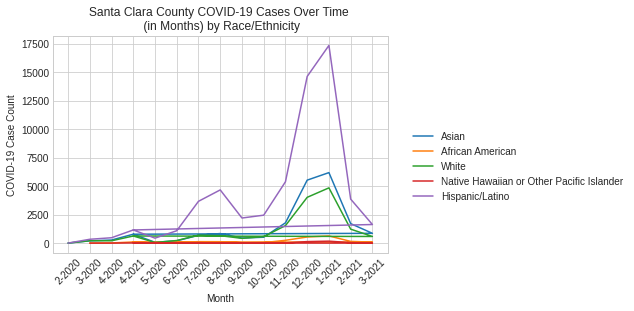

In [ ]:
# save the ethinicities/races
# as a list
races = list(set(monthly_cases_race['race_ethnicity']))

# plot the monthly covid cases by race

import matplotlib.pyplot as plt
# initialize graph commands
plt.style.use('seaborn-whitegrid')
fig = plt.figure()  # empty figure container
ax = plt.axes()     # default axes

# plot the death counts for each race 
for i in range(len(races)):
    dates = monthly_cases_race_melt['date'][(monthly_cases_race_melt.race_ethnicity==races[i])].values
    deaths = monthly_cases_race_melt['case_count'][(monthly_cases_race_melt.race_ethnicity==races[i])].values
    plt.plot(dates, deaths, label=races[i] )
    plt.xticks(rotation = 45) 
    plt.legend(bbox_to_anchor = (1.05, 0.6));

# create labels
plt.title('Santa Clara County COVID-19 Cases Over Time \n (in Months) by Race/Ethnicity')
plt.xlabel('Month')
plt.ylabel('COVID-19 Case Count')

# plotting commands
plt.show();

The labor force counts for each of the observed counties is shown below:

**Santa Clara County**

In [ ]:
import pandas as pd
import numpy as np

file = "Local_Area_Unemployment_Statistics__LAUS__-_Santa_Clara_County.csv"
data = pd.read_csv(file)

# rename year column in order to remove space
data.rename(columns={"Year ":"Year"}, inplace = True)

# filter data to only the recent years
SC_labor_part = data[(data.Year==2020)|(data.Year==2021)]

# create lists for the months
month_values = [1,2,3,4,5,6,7,8,9,10,11,12]
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

# map the lists
month_map = dict(zip(months,month_values))
month_map

#copy the dataset
SC_labor_partic = SC_labor_part.copy()

# map the months
SC_labor_partic.Month = SC_labor_partic.Month.map(month_map)

# sort rows by the year first then month
SC_labor_partic.sort_values(by=['Year','Month'],inplace=True)

# convert labor participation counts to floats
SC_labor_partic['Labor Force'] = SC_labor_partic['Labor Force'].str.replace(',', '').astype(float)

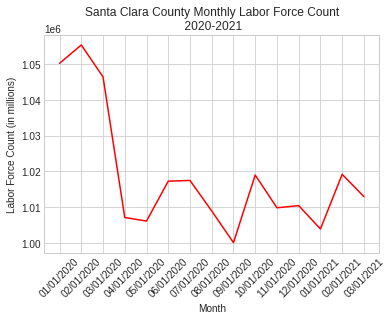

In [ ]:
# plot the labor force count

import matplotlib.pyplot as plt
# initialize graph commands
plt.style.use('seaborn-whitegrid')
fig = plt.figure()  # empty figure container
ax = plt.axes()     # default axes

# plot the death counts for each race 
plt.plot(SC_labor_partic['Date'], SC_labor_partic['Labor Force'], color ='r')
plt.xticks(rotation = 45) 
#plt.legend(bbox_to_anchor = (1.05, 0.6));

# create labels
plt.title('Santa Clara County Monthly Labor Force Count\n 2020-2021')
plt.xlabel('Month')
plt.ylabel('Labor Force Count (in millions)')

# plotting commands
plt.show();

**Sacramento County**

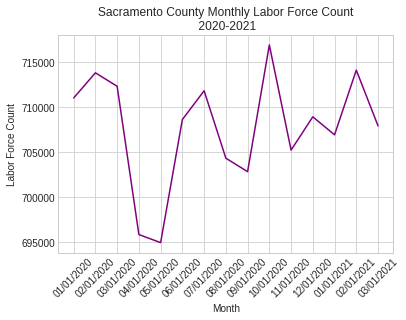

In [ ]:
file1 = "Local_Area_Unemployment_Statistics__LAUS__-_Sacramento_County.csv"
data = pd.read_csv(file1)

# rename the year column
data.rename(columns={"Year ":"Year"}, inplace = True)

# filter data to only the recent years
Sac_labor_part = data[(data.Year==2020)|(data.Year==2021)]
Sac_labor_part

# create a map associating
# numeric values of months
month_values = [1,2,3,4,5,6,7,8,9,10,11,12]
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

month_map = dict(zip(months,month_values))
month_map


# map the months
Sac_labor_partic = Sac_labor_part.copy()

Sac_labor_partic.Month = Sac_labor_partic.Month.map(month_map)

# sort rows by the year first then month
Sac_labor_partic.sort_values(by=['Year','Month'],inplace=True)
Sac_labor_partic

# convert labor participation counts to floats
Sac_labor_partic['Labor Force'] = Sac_labor_partic['Labor Force'].str.replace(',', '').astype(float)

# plot the labor force count

import matplotlib.pyplot as plt
# initialize graph commands
plt.style.use('seaborn-whitegrid')
fig = plt.figure()  # empty figure container
ax = plt.axes()     # default axes

# plot the death counts for each race 
plt.plot(Sac_labor_partic['Date'], Sac_labor_partic['Labor Force'],color ='purple')
plt.xticks(rotation = 45) 
#plt.legend(bbox_to_anchor = (1.05, 0.6));

# create labels
plt.title('Sacramento County Monthly Labor Force Count\n 2020-2021')
plt.xlabel('Month')
plt.ylabel('Labor Force Count')

# plotting commands
plt.show();

**Colusa County**

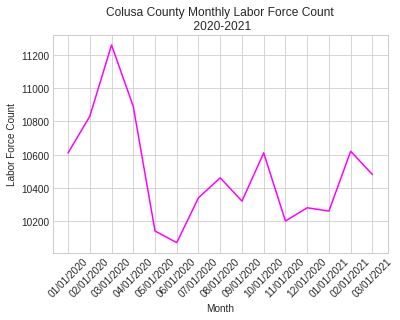

In [ ]:
file2 = "Local_Area_Unemployment_Statistics__LAUS__-_Colusa_County.csv"
data = pd.read_csv(file2)

# filter data to only the recent years
data.columns

# rename the year column
data.rename(columns={"Year ":"Year"}, inplace = True)

# filter data to only the recent years
Col_labor_part = data[(data.Year==2020)|(data.Year==2021)]
Col_labor_part

# create a map associating
# numeric values of months
month_values = [1,2,3,4,5,6,7,8,9,10,11,12]
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
month_map = dict(zip(months,month_values))


# map the months in the dataframe
Col_labor_partic = Col_labor_part.copy()
Col_labor_partic.Month = Col_labor_partic.Month.map(month_map)

# sort rows by the year first then month
Col_labor_partic.sort_values(by=['Year','Month'],inplace=True)

# convert labor participation counts to floats
Col_labor_partic['Labor Force'] = Col_labor_partic['Labor Force'].str.replace(',', '').astype(float)

# plot the labor force count

import matplotlib.pyplot as plt
# initialize graph commands
plt.style.use('seaborn-whitegrid')
fig = plt.figure()  # empty figure container
ax = plt.axes()     # default axes

# plot the death counts for each race 
plt.plot(Col_labor_partic['Date'], Col_labor_partic['Labor Force'],color ='magenta')
plt.xticks(rotation = 45) 
#plt.legend(bbox_to_anchor = (1.05, 0.6));

# create labels
plt.title('Colusa County Monthly Labor Force Count\n 2020-2021')
plt.xlabel('Month')
plt.ylabel('Labor Force Count')

# plotting commands
plt.show();

**Los Angeles County**

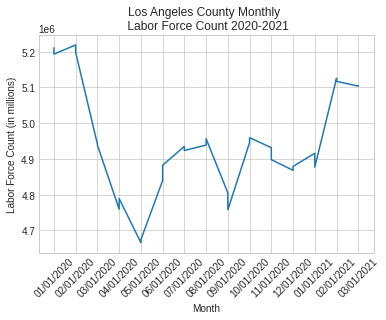

In [ ]:
file3 = "Local_Area_Unemployment_Statistics__LAUS__-_Los_Angeles_County.csv"
data = pd.read_csv(file3)

# filter data to only the recent years
data.columns

# rename the year column
data.rename(columns={"Year ":"Year"}, inplace = True)

# filter data to only the recent years
LA_labor_part = data[(data.Year==2020)|(data.Year==2021)]
LA_labor_part

# create a map associating
# numeric values of months
month_values = [1,2,3,4,5,6,7,8,9,10,11,12]
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

month_map = dict(zip(months,month_values))
month_map


# map the months

LA_labor_partic = LA_labor_part.copy()
LA_labor_partic.Month = LA_labor_partic.Month.map(month_map)

# sort rows by the year first then month
LA_labor_partic.sort_values(by=['Year','Month'],inplace=True)
LA_labor_partic

# convert labor participation counts to floats
LA_labor_partic['Labor Force'] = LA_labor_partic['Labor Force'].str.replace(',', '').astype(float)
LA_labor_partic

# plot the labor force count

import matplotlib.pyplot as plt
# initialize graph commands
plt.style.use('seaborn-whitegrid')
fig = plt.figure()  # empty figure container
ax = plt.axes()     # default axes

# plot the death counts for each race 
plt.plot(LA_labor_partic['Date'], LA_labor_partic['Labor Force'])
plt.xticks(rotation = 45) 
#plt.legend(bbox_to_anchor = (1.05, 0.6));

# create labels
plt.title('Los Angeles County Monthly \n Labor Force Count 2020-2021')
plt.xlabel('Month')
plt.ylabel('Labor Force Count (in millions)')

# plotting commands
plt.show();